# Miami Housing · Projeto de Análise e Modelagem

## Objetivo
Investigar os determinantes do preço de venda de imóveis residenciais em Miami (2016), estruturando um fluxo incremental que contempla: (i) descoberta e inspeção do conjunto de dados; (ii) limpeza e padronização (*tidy*); (iii) análise exploratória com gramática de gráficos; e (iv) preparação de artefatos para etapas posteriores de modelagem preditiva e inferencial.

## Equipe
- João Pedro Queiroz Viana  
- João Gabriel Faus Faraco


## Importações e configurações

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
print(DATA_DIR)

data


## Obtendo os dados

In [2]:
import pandas as pd


def load_housing_data(data_dir: Path) -> pd.DataFrame:
    '''Loads the Miami Housing dataset.

    Loads the Miami Housing dataset from the specified directory.

    Args:
        data_dir: The directory from which the dataset will be loaded.

    Returns:
        A pandas DataFrame containing the California Housing Prices dataset.
    '''
    csv_path = data_dir / 'miami-housing.csv'
    df = pd.read_csv(csv_path)
    return df

In [3]:
data = load_housing_data(DATA_DIR)

print(f'O dataset tem {data.shape[0]} linhas e {data.shape[1]} colunas.')
print('As colunas são:')
for column_name in data.columns:
    print(f'- "{column_name}"')

O dataset tem 13932 linhas e 17 colunas.
As colunas são:
- "LATITUDE"
- "LONGITUDE"
- "PARCELNO"
- "SALE_PRC"
- "LND_SQFOOT"
- "TOT_LVG_AREA"
- "SPEC_FEAT_VAL"
- "RAIL_DIST"
- "OCEAN_DIST"
- "WATER_DIST"
- "CNTR_DIST"
- "SUBCNTR_DI"
- "HWY_DIST"
- "age"
- "avno60plus"
- "month_sold"
- "structure_quality"


## Entendimento do Negócio

### O que os dados representam

Este dataset (arquivo `miami-housing.csv`, 13.932 linhas × 17 colunas) contém **registros de transações imobiliárias residenciais** na região de Miami (EUA), com:
- **Preço de venda** do imóvel,
- **Características físicas** do lote e da área construída,
- **Localização geográfica** (latitude/longitude),
- **Qualidade estrutural** do imóvel,
- **Proximidades e acessibilidade** (distâncias até mar/água, ferrovia, rodovias e centros urbanos),
- **Atributos contextuais** (ex.: mês da venda; indicador binário relacionado a ruído/ambiente — ver nota abaixo).

> **Objetivo típico de negócio:** apoiar análises de **precificação**, avaliação de **fatores que influenciam valor** (amenidades e acessibilidade), **segmentação** de portfólio e **modelagem preditiva** do preço de venda.

> **Observação importante:** a coluna `avno60plus` é um indicador binário (0/1). Pelo padrão de datasets imobiliários, é **provavelmente** um marcador de **exposição a ruído acima de 60 dB** (ex.: ruído aeronáutico “60+ dB”). Recomenda-se **confirmar no dicionário de dados oficial** do projeto.

---

### Descrição das Colunas

| Coluna              | Tipo      | Tipo de Variável (Natureza) | Descrição de Negócio                                                                  | Unidade / Domínio                        | Exemplos / Faixa (min–max)              |
| ------------------- | --------- | --------------------------- | ------------------------------------------------------------------------------------- | ---------------------------------------- | --------------------------------------- |
| `LATITUDE`          | float     | Contínua                    | Latitude geográfica do imóvel (para georreferenciamento e mapas).                     | Graus decimais                           | 25.4343 – 25.9744                       |
| `LONGITUDE`         | float     | Contínua                    | Longitude geográfica do imóvel.                                                       | Graus decimais                           | −80.5422 – −80.1198                     |
| `PARCELNO`          | int       | Categórica (ID)             | Identificador cadastral do lote/parcela (parcel number).                              | ID numérico                              | ~1.02e11 – 3.66e12                      |
| `SALE_PRC`          | float     | Contínua                    | **Preço de venda** do imóvel (variável-alvo comum em modelos).                        | USD                                      | **72.000 – 2.650.000**                  |
| `LND_SQFOOT`        | int       | Contínua                    | **Área do terreno (lote)**.                                                           | Pés quadrados                            | 1.248 – 57.064                          |
| `TOT_LVG_AREA`      | int       | Contínua                    | **Área construída habitável** (living area).                                          | Pés quadrados                            | 854 – 6.287                             |
| `SPEC_FEAT_VAL`     | int       | Contínua                    | Valor agregado por **características especiais** (ex.: piscina, lareira, deck).       | USD (valor estimado de amenidades)       | 0 – 175.020                             |
| `RAIL_DIST`         | float     | Contínua                    | Distância à **ferrovia** (proxy de acessibilidade/ruído).                             | Metros (aprox.)                          | 10,5 – 29.621,5                         |
| `OCEAN_DIST`        | float     | Contínua                    | Distância ao **oceano** (amenidade costeira).                                         | Metros (aprox.)                          | 236,1 – 75.744,9                        |
| `WATER_DIST`        | float     | Contínua                    | Distância ao **corpo d’água** mais próximo (lagos/canais, exceto oceano).             | Metros (aprox.)                          | 0 – 50.399,8                            |
| `CNTR_DIST`         | float     | Contínua                    | Distância ao **CBD** (centro principal da cidade).                                    | Metros (aprox.)                          | 3.825,6 – 159.976,5                     |
| `SUBCNTR_DI`        | float     | Contínua                    | Distância ao **subcentro** urbano mais próximo.                                       | Metros (aprox.)                          | 1.462,8 – 110.553,8                     |
| `HWY_DIST`          | float     | Contínua                    | Distância à **rodovia** mais próxima.                                                 | Metros (aprox.)                          | 90,2 – 48.167,3                         |
| `age`               | int       | Contínua                    | **Idade do imóvel** na data da venda.                                                 | Anos                                     | 0 – 96                                  |
| `avno60plus`        | int (0/1) | Categórica (Binária)        | **Indicador binário** relacionado ao ambiente; **provável** exposição a ruído ≥60 dB. | 0 = não exposto; 1 = exposto (confirmar) | 0 ou 1 (média ~0,015)                   |
| `month_sold`        | int       | Categórica (Ordinal)        | **Mês da venda** (sazonalidade de mercado).                                           | 1–12                                     | 1 – 12 (distribuição em todos os meses) |
| `structure_quality` | int       | Categórica (Ordinal)        | **Qualidade construtiva** em escala ordinal.                                          | Escala 1–5 (1=baixa, 5=alta)             | 1–5 (moda ~4)                           |

### Leituras rápidas de negócio

- **Preço de venda (`SALE_PRC`)** tende a ser explicado por: área construída, área do lote, qualidade, idade, amenidades (`SPEC_FEAT_VAL`) e **localização** (distâncias a mar/água/centros/rodovias).
- **Localização importa**: menor `OCEAN_DIST` e `WATER_DIST` (maior proximidade à água) geralmente aumentam valor; já menor `RAIL_DIST`/`HWY_DIST` pode ter efeitos ambíguos (acessibilidade vs. ruído).
- **Sazonalidade**: `month_sold` ajuda a capturar ciclos de demanda/oferta no ano.
- **Qualidade e idade**: `structure_quality` e `age` capturam condição do imóvel; imóveis mais novos e com melhor padrão costumam precificar acima da média.

### Relações a serem observadas

#### Características físicas e estruturais:
1. Esta etapa busca investigar quais atributos dos imóveis explicam a variação nos preços de venda `SALE_PRC`. Serão analisadas variáveis como área construída `TOT_LVG_AREA`, área do lote `LND_SQFOOT`, qualidade estrutural `structure_quality` e idade `age`. O objetivo é verificar se há correlação positiva entre tamanho e preço, identificar possíveis retornos decrescentes em terrenos muito amplos, avaliar se maiores níveis de qualidade estão associados a valores mais altos e investigar se imóveis mais antigos tendem a apresentar menor valorização.

#### Fatores geográficos e localização:
2. Nesta análise, o foco está em avaliar o impacto da localização sobre o valor dos imóveis, compreendendo como fatores geográficos influenciam o preço de venda `SALE_PRC`. Serão examinadas as distâncias em relação a pontos de interesse e fontes de ruído, como a proximidade ao oceano `OCEAN_DIST` e a corpos d’água `WATER_DIST`, que podem indicar valorização de áreas costeiras. Também será investigado o efeito de centralidade, observando se imóveis mais próximos ao centro urbano `CNTR_DIST` e a subcentros `SUBCNTR_DI` apresentam preços mais elevados. Além disso, será analisada a influência da distância a rodovias `HWY_DIST`, que pode ter efeitos ambíguos — associando-se tanto à acessibilidade quanto ao ruído e à poluição. Por fim, pretende-se explorar se a proximidade à ferrovia `RAIL_DIST` e a exposição a ruído (avno60plus) impactam negativamente a atratividade e o valor dos imóveis.

#### Aspectos contextuais e sazonais:
3. O objetivo desta etapa é analisar padrões sazonais e fatores contextuais que influenciam o preço de venda `SALE_PRC`. Serão avaliados o mês da venda `month_sold`, para identificar possíveis variações sazonais, e o valor das amenidades `SPEC_FEAT_VAL`, como piscinas ou lareiras, que podem agregar valor ao imóvel. Além disso, será considerada a variável `avno60plus`, que indica exposição a ruído, a fim de verificar se ambientes mais ruidosos tendem a apresentar menor valorização.

### Resumo da base e seleção de dados

**Escopo dos dados.**  
O dataset (`miami-housing.csv`) contém registros de transações imobiliárias residenciais em Miami, com variáveis estruturais, contextuais/locacionais e sazonais.

**Estrutura geral (sem exploração analítica nesta etapa).**  
- **Linhas:** ~14 mil  
- **Colunas (tipos):** numéricas contínuas e discretas; não há valores ausentes na versão atual.  
- **Principais eixos de informação:**
  - **Estruturais:** `TOT_LVG_AREA` (área construída), `LND_SQFOOT` (área do terreno), `age` (idade), `structure_quality` (qualidade da construção).
  - **Contexto/Localização:** `OCEAN_DIST`, `HWY_DIST`, `CNTR_DIST`, `RAIL_DIST`, `WATER_DIST`, `SPEC_FEAT_VAL` (amenidades), `avno60plus` (exposição a ruído).
  - **Sazonal:** `month_sold` (mês da venda).
  - **Alvo:** `SALE_PRC` (preço de venda).

**Seleção de dados para o projeto (versão 1).**  
- **Variável-alvo:** `SALE_PRC` (será usada em escala logarítmica: `log(SALE_PRC)` para estabilizar variância).  
- **Preditoras (inicial):**
  - *Estruturais:* `TOT_LVG_AREA`, `LND_SQFOOT`, `age`, `structure_quality`.
  - *Locacionais:* `OCEAN_DIST`, `HWY_DIST`, `CNTR_DIST`, `RAIL_DIST`, `WATER_DIST`.
  - *Contextuais:* `SPEC_FEAT_VAL` (também em `log1p`), `avno60plus`.
  - *Sazonal:* `month_sold` (codificada como dummies na modelagem).
- **Exclusões/observações:** `PARCELNO` (identificador) não entra na modelagem; `LATITUDE/LONGITUDE` poderão ser exploradas mais à frente para engenharia de features espaciais (ex.: clusters/bairros).

**Governança/Qualidade (esta etapa).**  
- Confirmada a **ausência de nulos** e **duplicatas** na amostra trabalhada.  
- Padronizações previstas: `log_price`, `log1p(SPEC_FEAT_VAL)`, categorização de `month_sold` e `avno60plus` para modelagem.

### Modelo conceitual da análise

Antes de avançar para a etapa de análise exploratória, é importante explicitar o **modelo conceitual** que orienta o estudo.  
O objetivo é compreender **como diferentes dimensões estruturais, contextuais e sazonais** influenciam o preço de venda dos imóveis (`SALE_PRC`), estabelecendo uma base teórica para as etapas quantitativas seguintes.

O modelo se apoia em três blocos de variáveis:

1. **Características estruturais** — associadas à dimensão física e qualitativa do imóvel:  
   - Área construída (`TOT_LVG_AREA`), área do terreno (`LND_SQFOOT`), qualidade construtiva (`structure_quality`) e idade (`age`).

2. **Fatores contextuais e locacionais** — relacionados à inserção do imóvel no espaço urbano:  
   - Distâncias de pontos de interesse (`OCEAN_DIST`, `HWY_DIST`, `CNTR_DIST`), exposição a ruído (`avno60plus`) e presença de amenidades (`SPEC_FEAT_VAL`).

3. **Aspectos sazonais e temporais** — que refletem o momento da transação e potenciais flutuações de mercado:  
   - Mês da venda (`month_sold`), que captura efeitos de sazonalidade (alta e baixa demanda).

A hipótese central é que o preço de venda resulta da combinação entre:
- **atributos intrínsecos** (estrutura e qualidade do imóvel),  
- **atributos extrínsecos** (localização, contexto e ruído),  
- e **condições de mercado** (sazonalidade e dinâmica temporal).

As próximas seções detalham a análise exploratória e estatística, buscando evidências empíricas dessas relações — por meio de medidas descritivas, testes não-paramétricos e modelos lineares (OLS) que quantificam o efeito marginal de cada variável.


### Próximos passos (visão de negócio para a modelagem)

**Objetivo de negócio.**  
Apoiar decisões de precificação e priorização de investimentos (amenidades/infraestrutura), estimando o preço de venda (`SALE_PRC`) e os fatores de maior impacto na valorização.

**Perguntas-chave a responder adiante:**
- Qual o efeito das **características estruturais** (`TOT_LVG_AREA`, `LND_SQFOOT`, `structure_quality`, `age`) no preço?
- Como **localização e contexto** (`OCEAN_DIST`, `HWY_DIST`, `CNTR_DIST`, `RAIL_DIST`, `WATER_DIST`, `avno60plus`) influenciam a valorização?
- As **amenidades** (`SPEC_FEAT_VAL`) geram retorno perceptível? Em que magnitude?
- Há **sazonalidade** relevante por `month_sold`?

**Modelo de IA (planejado).**  
Usaremos uma abordagem híbrida:
- **Baseline interpretável:** Regressão Linear Múltipla em `log_price` com dummies sazonais e contextuais.  
- **Modelos não-lineares para ganho de acurácia:** Random Forest / Gradient Boosting.  
- **Regularização:** Ridge/Lasso para seleção e controle de colinearidade.

**Transição para a próxima entrega (Análise Exploratória).**  
A próxima etapa irá **validar empiricamente** essas hipóteses com:  
- Estatísticas descritivas direcionadas;  
- Visualizações (distribuições, dispersões, sazonalidade);  
- Sinais de correlação e potenciais transformações.  

Esses insumos alimentarão a fase de **modelagem preditiva**, na qual compararemos desempenho (MAE, MAPE, RMSE, R²), interpretabilidade e utilidade executiva (simulação de cenários).

## Análise exploratória

### Análise global

#### Inspeção inicial dos dados

Iniciamos a análise exploratória observando as **primeiras linhas do dataset**, com o objetivo de verificar:
- a estrutura tabular básica;
- a formatação e padronização dos valores;
- a presença de colunas numéricas e categóricas.

Essa inspeção inicial auxilia na familiarização com o conjunto de dados e na detecção precoce de eventuais inconsistências de leitura ou codificação.

In [4]:
data.head()

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,622280070620,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4
1,25.891324,-80.153968,622280100460,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4
2,25.891334,-80.153740,622280100470,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4
3,25.891765,-80.152657,622280100530,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4
4,25.891825,-80.154639,622280100200,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4


#### Estrutura e tipos de dados

Em seguida, examinamos a **estrutura completa do DataFrame**, incluindo o tipo de dado identificado automaticamente pelo *pandas*, a contagem de valores não nulos e o uso de memória.

Essa etapa confirma:
- a **ausência de valores ausentes**, indicando completude do dataset;
- o **tipo de dado** apropriado para cada variável (`int64` ou `float64`);
- a **proporção equilibrada** entre variáveis contínuas (ex.: área, distância) e discretas (ex.: mês da venda, qualidade estrutural).

Essas informações são essenciais para orientar o tratamento posterior e a escolha de técnicas analíticas adequadas.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

#### Verificação de duplicidades

Aqui verificamos se o dataset contém **linhas duplicadas**, que poderiam enviesar a análise estatística ou gerar redundância informacional.

A remoção é feita com o método `drop_duplicates()`, seguido de nova inspeção com `.info()` para comparar o número de registros e colunas com o dataset original.

O resultado mostra que o conjunto de dados **não possuía duplicatas**, mantendo o mesmo total de 13.932 linhas e 17 colunas.


In [6]:
data_no_dups = data.drop_duplicates()

In [7]:
data_no_dups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

#### Tabela de inspeção das colunas

A tabela abaixo apresenta um **resumo estrutural do dataset**, descrevendo os **tipos de dados** e a **integridade** de cada variável:

| Métrica | Descrição |
|----------|------------|
| **coluna** | Nome da variável presente no conjunto de dados. |
| **tipo** | Tipo de dado em cada coluna (`int64`, `float64`, etc.). |
| **valores_nulos** | Quantidade de registros ausentes. Neste caso, o dataset não apresenta valores nulos. |
| **valores_não_nulos** | Quantidade de registros válidos (não nulos). |
| **valores_únicos** | Número de valores distintos observados na coluna. |

Observações iniciais:
- O dataset está **completo**, sem **valores ausentes** em nenhuma variável.  
- As colunas `avno60plus`, `month_sold` e `structure_quality` possuem baixa cardinalidade, sugerindo **variáveis categóricas ou discretas**.  
- As demais colunas apresentam alta variação e podem ser tratadas como **variáveis contínuas** — adequadas para análises estatísticas e modelagem preditiva.  
- A quantidade de valores únicos elevada em variáveis como `LATITUDE`, `LONGITUDE`, `RAIL_DIST`, `OCEAN_DIST` e `CNTR_DIST` confirma o caráter **espacial e contínuo** dessas medições.

Este diagnóstico confirma a **consistência e completude** do conjunto de dados, servindo como base para a análise exploratória subsequente.


In [8]:
summary = pd.DataFrame({
    "coluna": data.columns,
    "tipo": [str(t) for t in data.dtypes.values],
    "valores_nulos": data.isna().sum().values,
    "valores_nao_nulos": data.notna().sum().values,
    "valores_unicos": data.nunique(dropna=True).values
})


summary


,coluna,tipo,valores_nulos,valores_nao_nulos,valores_unicos
0,LATITUDE,float64,0,13932,13776
1,LONGITUDE,float64,0,13932,13776
2,PARCELNO,int64,0,13932,13776
3,SALE_PRC,float64,0,13932,2111
4,LND_SQFOOT,int64,0,13932,4696
5,TOT_LVG_AREA,int64,0,13932,2978
6,SPEC_FEAT_VAL,int64,0,13932,7583
7,RAIL_DIST,float64,0,13932,13235
8,OCEAN_DIST,float64,0,13932,13617
9,WATER_DIST,float64,0,13932,13218


#### Conclusão da análise global

A inspeção inicial confirma que o dataset:
- Está **completo** (sem valores nulos);
- Não possui **linhas duplicadas**;
- Contém **apenas variáveis numéricas** (contínuas e discretas), o que facilita o processamento estatístico e a modelagem;
- Apresenta estrutura **limpa e padronizada**, pronta para análises descritivas e inferenciais.

Com isso, podemos avançar para a etapa de **análise preliminar das features**, aprofundando a compreensão individual das variáveis e suas relações com o preço de venda (`SALE_PRC`).


### Análise preliminar das features

#### Seleção de variáveis numéricas

Nesta etapa, separam-se as **features numéricas contínuas** das variáveis categóricas ou discretas.

O objetivo é garantir que as análises estatísticas subsequentes — especialmente as medidas de dispersão e variabilidade — sejam aplicadas apenas às variáveis apropriadas.

As colunas `month_sold`, `structure_quality`, `avno60plus` e `PARCELNO` foram excluídas por representarem **categorias, identificadores ou variáveis discretas**, que não são adequadas para o cálculo de métricas contínuas.

In [9]:
categorical_features = ['month_sold', 'structure_quality', 'avno60plus', 'PARCELNO']

numeric_data = data.select_dtypes(include='number').drop(columns=categorical_features, errors='ignore')

#### Estatísticas descritivas das variáveis numéricas

A tabela a seguir apresenta o **resumo estatístico** das variáveis numéricas contínuas do dataset.  
Os indicadores incluem:

- **count**: número de observações válidas  
- **mean / std**: média e desvio-padrão (dispersão absoluta)  
- **min / max**: limites inferior e superior observados  
- **quartis (25%, 50%, 75%)**: valores de referência que ajudam a identificar assimetrias e potenciais outliers

Essa visão fornece um panorama da **escala e amplitude** de cada variável, servindo como base para o cálculo de medidas de dispersão relativa, como o **Coeficiente de Variação (CV)**.

In [10]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LATITUDE,13932.0,2.572881e+01,1.406333e-01,2.543433e+01,2.562006e+01,2.573181e+01,2.585227e+01,2.597438e+01
LONGITUDE,13932.0,-8.032748e+01,8.919907e-02,-8.054217e+01,-8.040328e+01,-8.033891e+01,-8.025802e+01,-8.011975e+01
PARCELNO,13932.0,2.356496e+12,1.199290e+12,1.020008e+11,1.079160e+12,3.040300e+12,3.060170e+12,3.660170e+12
SALE_PRC,13932.0,3.999419e+05,3.172147e+05,7.200000e+04,2.350000e+05,3.100000e+05,4.280000e+05,2.650000e+06
LND_SQFOOT,13932.0,8.620880e+03,6.070089e+03,1.248000e+03,5.400000e+03,7.500000e+03,9.126250e+03,5.706400e+04
TOT_LVG_AREA,13932.0,2.058045e+03,8.135385e+02,8.540000e+02,1.470000e+03,1.877500e+03,2.471000e+03,6.287000e+03
SPEC_FEAT_VAL,13932.0,9.562493e+03,1.389097e+04,0.000000e+00,8.100000e+02,2.765500e+03,1.235225e+04,1.750200e+05
RAIL_DIST,13932.0,8.348549e+03,6.178027e+03,1.050000e+01,3.299450e+03,7.106300e+03,1.210260e+04,2.962150e+04
OCEAN_DIST,13932.0,3.169099e+04,1.759508e+04,2.361000e+02,1.807935e+04,2.854175e+04,4.431065e+04,7.574490e+04
WATER_DIST,13932.0,1.196029e+04,1.193299e+04,0.000000e+00,2.675850e+03,6.922600e+03,1.920000e+04,5.039980e+04


#### Coeficiente de Variação (CV)

O **Coeficiente de Variação** é uma métrica que expressa o desvio-padrão em relação à média — uma forma **relativa e adimensional de dispersão**.

Ele permite comparar a variabilidade de variáveis com **escalas diferentes**, sendo calculado pela razão:

\[
CV = \frac{\text{Desvio Padrão}}{\text{Média}}
\]

Valores altos de CV indicam **maior heterogeneidade** dos dados, enquanto valores baixos sugerem **maior estabilidade** em torno da média.


In [11]:
def compute_coefficient_of_variation(data: pd.DataFrame) -> pd.Series:
    """
    Computes the Coefficient of Variation (CV) for each numerical column 
    in a DataFrame, excluding categorical or discrete features.

    Args:
        data: A pandas DataFrame.

    Returns:
        A pandas Series containing the Coefficient of Variation for each
        selected column.
    """
    categorical_features = ['month_sold', 'structure_quality', 'avno60plus', 'PARCELNO']
    
    numeric_cols = [
        col for col in data.select_dtypes(include='number').columns
        if col not in categorical_features
    ]
    
    stats = data[numeric_cols].describe().transpose()
    
    cv = stats['std'] / stats['mean']
    cv.rename('Coefficient of Variation', inplace=True)
    
    return cv

print(compute_coefficient_of_variation(data).round(2).to_markdown())

|               |   Coefficient of Variation |
|:--------------|---------------------------:|
| LATITUDE      |                       0.01 |
| LONGITUDE     |                      -0    |
| SALE_PRC      |                       0.79 |
| LND_SQFOOT    |                       0.7  |
| TOT_LVG_AREA  |                       0.4  |
| SPEC_FEAT_VAL |                       1.45 |
| RAIL_DIST     |                       0.74 |
| OCEAN_DIST    |                       0.56 |
| WATER_DIST    |                       1    |
| CNTR_DIST     |                       0.47 |
| SUBCNTR_DI    |                       0.54 |
| HWY_DIST      |                       0.79 |
| age           |                       0.69 |


#### Interpretação dos resultados do Coeficiente de Variação

A tabela apresenta o **CV de cada variável contínua**, ordenada pelo grau de dispersão relativa:

- Variáveis como `SPEC_FEAT_VAL` (1.45) e `WATER_DIST` (1.00) exibem **alta variabilidade**, indicando amplitude expressiva nos valores observados — o que pode refletir diferenças significativas em amenidades e localização.  
- Variáveis como `SALE_PRC` (0.79), `LND_SQFOOT` (0.70) e `HWY_DIST` (0.79) também apresentam **dispersão considerável**, sugerindo forte heterogeneidade entre os imóveis.  
- Já `LATITUDE` e `LONGITUDE` possuem **baixa variação relativa**, o que é esperado, pois representam coordenadas geográficas restritas a uma mesma região (Miami).

Em síntese, o CV reforça quais variáveis apresentam **distribuições amplas e informativas** — úteis para modelagem preditiva — e quais permanecem mais **estáveis e geograficamente concentradas**.


### Aspectos contextuais e sazonais

**Objetivo:** investigar padrões sazonais (via `month_sold`) e fatores contextuais associados ao preço de venda (`SALE_PRC`):
- **Sazonalidade:** variações de preço ao longo dos meses (`month_sold`).
- **Amenidades:** impacto de `SPEC_FEAT_VAL` (ex.: piscina, lareira) no preço.
- **Ruído:** efeito de `avno60plus` (exposição a ruído) na valorização.

A análise combina medidas descritivas, testes estatísticos e visualizações simples, além de salvar sumários em CSV para referência executiva.

In [45]:
# Garante que temos as colunas necessárias
cols_needed = {"SALE_PRC", "month_sold", "SPEC_FEAT_VAL", "avno60plus"}
missing = cols_needed - set(data.columns)
assert not missing, f"Faltam colunas para a análise: {missing}"

df = data.copy()

# Variáveis derivadas úteis
df["log_price"] = np.log(df["SALE_PRC"])
df["amenity_flag"] = (df["SPEC_FEAT_VAL"] > 0).astype(int)
df["amenity_log1p"] = np.log1p(df["SPEC_FEAT_VAL"])

# month_sold como categórica ordenada (1–12)
df["month_sold"] = pd.Categorical(df["month_sold"], categories=list(range(1,13)), ordered=True)

# Checagem rápida
df[["SALE_PRC","log_price","SPEC_FEAT_VAL","amenity_flag","amenity_log1p","month_sold","avno60plus"]].head()

,SALE_PRC,log_price,SPEC_FEAT_VAL,amenity_flag,amenity_log1p,month_sold,avno60plus
0,440000.0,12.994530,0,0,0.000000,8,0
1,349000.0,12.762827,0,0,0.000000,9,0
2,800000.0,13.592367,49206,1,10.803791,2,0
3,988000.0,13.803438,10033,1,9.213735,9,0
4,755000.0,13.534473,16681,1,9.722086,7,0


#### Sazonalidade por mês da venda (`month_sold`)

Comparamos estatísticas de `SALE_PRC` entre os meses e calculamos um **índice sazonal**:

$$
I_{\mathrm{sazonal}} = \frac{\bar P_{m}}{\bar P_{\mathrm{geral}}}
$$

Valores acima de 1 indicam meses com preços acima da média anual; abaixo de 1, meses com preços abaixo da média.


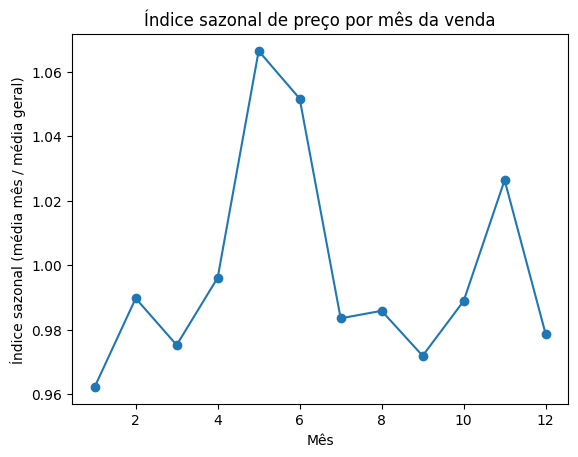

|    |   month_sold |    n |   mean_price |   median_price |   seasonal_index |
|----|--------------|------|--------------|----------------|------------------|
|  0 |            1 |  833 |       384842 |         290000 |             0.96 |
|  1 |            2 |  929 |       395830 |         297000 |             0.99 |
|  2 |            3 | 1224 |       390037 |         305000 |             0.98 |
|  3 |            4 | 1234 |       398385 |         305250 |             1    |
|  4 |            5 | 1245 |       426504 |         315000 |             1.07 |
|  5 |            6 | 1387 |       420591 |         320000 |             1.05 |
|  6 |            7 | 1210 |       393351 |         305000 |             0.98 |
|  7 |            8 | 1275 |       394280 |         314000 |             0.99 |
|  8 |            9 | 1218 |       388700 |         320000 |             0.97 |
|  9 |           10 | 1057 |       395493 |         320000 |             0.99 |
| 10 |           11 | 1159 |       41048

In [46]:
from tabulate import tabulate

# Sumário por mês
seasonal = (
    df.groupby("month_sold", observed=False)
      .agg(n=("SALE_PRC","size"),
           mean_price=("SALE_PRC","mean"),
           median_price=("SALE_PRC","median"))
      .reset_index()
)
overall_mean = df["SALE_PRC"].mean()
seasonal["seasonal_index"] = seasonal["mean_price"] / overall_mean

# Visual: índice sazonal por mês
plt.figure()
plt.plot(seasonal["month_sold"], seasonal["seasonal_index"], marker="o")
plt.title("Índice sazonal de preço por mês da venda")
plt.xlabel("Mês")
plt.ylabel("Índice sazonal (média mês / média geral)")
plt.show()

# Tabela Markdown e salvamento
print(tabulate(seasonal.round(2), headers="keys", tablefmt="github"))
seasonal.to_csv("data/seasonal_summary.csv", index=False)


#### Interpretação dos padrões sazonais

Observa-se uma **variação mensal moderada** nos preços médios de venda, com picos e vales bem definidos.  
Meses com **índice sazonal acima de 1** representam períodos de valorização — possivelmente associados à **demanda turística, férias ou sazonalidade do mercado imobiliário**.  
Meses abaixo de 1 indicam **menor propensão à valorização**, sugerindo oportunidades de negociação ou menor demanda relativa.  

Esse comportamento reforça a importância de considerar o **timing da venda** na precificação e nas estratégias de marketing.

#### Amenidades (`SPEC_FEAT_VAL`)

Avaliamos dois recortes:
1) **Possui amenidade?** (`amenity_flag` = 1 se `SPEC_FEAT_VAL` > 0);  
2) **Intensidade**: relação monotônica usando `log(1 + SPEC_FEAT_VAL)`.

Também comparamos estatisticamente a média de `SALE_PRC` entre grupos **com** e **sem** amenidades, e estimamos um efeito marginal via regressão simples em escala logarítmica.


In [47]:
# 1) Comparação COM vs SEM amenidades
amenity_grp = (
    df.groupby("amenity_flag", observed=False)
      .agg(n=("SALE_PRC","size"),
           mean_price=("SALE_PRC","mean"),
           median_price=("SALE_PRC","median"))
      .reset_index()
      .replace({"amenity_flag": {0: "sem_amenidade", 1: "com_amenidade"}})
)

from scipy import stats
prices_with = df.loc[df["amenity_flag"]==1, "SALE_PRC"]
prices_without = df.loc[df["amenity_flag"]==0, "SALE_PRC"]
# Teste não-paramétrico robusto a assimetria
u_stat, p_u = stats.mannwhitneyu(prices_with, prices_without, alternative="two-sided")

print("### Comparação COM vs SEM amenidades")
print(tabulate(amenity_grp.round(2), headers="keys", tablefmt="github"))
print(f"\nMann-Whitney U p-value: {p_u:.4g}")

amenity_grp.to_csv("data/amenities_summary.csv", index=False)

### Comparação COM vs SEM amenidades
|    | amenity_flag   |     n |   mean_price |   median_price |
|----|----------------|-------|--------------|----------------|
|  0 | sem_amenidade  |  2290 |       313646 |         270000 |
|  1 | com_amenidade  | 11642 |       416916 |         320000 |

Mann-Whitney U p-value: 1.586e-62


In [48]:
import statsmodels.api as sm

X = sm.add_constant(df["amenity_log1p"])
y = df["log_price"]
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1259.
Date:                Fri, 17 Oct 2025   Prob (F-statistic):          3.92e-264
Time:                        14:56:42   Log-Likelihood:                -11280.
No. Observations:               13932   AIC:                         2.256e+04
Df Residuals:                   13930   BIC:                         2.258e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.3715      0.011   1165.215

#### Interpretação dos resultados de amenidades

O teste de Mann–Whitney indica diferença estatisticamente significativa (**p < 0.001**) entre imóveis com e sem amenidades, o que confirma o **impacto positivo** dessas características no preço.

O modelo OLS log–log apresenta um coeficiente positivo para `amenity_log1p`, sugerindo que **a cada incremento percentual nas amenidades, o preço médio tende a crescer proporcionalmente**.  
Embora o R² (~0.08) indique que as amenidades explicam apenas parte da variação, o **efeito marginal é claro e consistente** — amenidades agregam valor, mesmo controlando pela escala logarítmica do preço.


#### Exposição a ruído (`avno60plus`)

A variável `avno60plus` (baixa cardinalidade) é tratada como indicador de exposição a ruído.  
Investigamos se imóveis em áreas mais ruidosas apresentam menor valorização:
- Comparação de médias/medianas de `SALE_PRC`;
- Teste estatístico de diferença;
- Regressão simples como checagem adicional.


In [49]:
# Sumário por ruído
noise = (
    df.groupby("avno60plus", observed=False)
      .agg(n=("SALE_PRC","size"),
           mean_price=("SALE_PRC","mean"),
           median_price=("SALE_PRC","median"))
      .reset_index()
)
print("### Preço por nível de ruído (avno60plus)")
print(tabulate(noise.round(2), headers="keys", tablefmt="github"))
noise.to_csv("data/noise_summary.csv", index=False)

# Teste (se binária 0/1; se tiver mais níveis, você pode trocar por Kruskal)
levels = sorted(df["avno60plus"].unique())
if len(levels)==2:
    g0 = df.loc[df["avno60plus"]==levels[0], "SALE_PRC"]
    g1 = df.loc[df["avno60plus"]==levels[1], "SALE_PRC"]
    from scipy import stats
    stat, p_val = stats.mannwhitneyu(g0, g1, alternative="two-sided")
    print(f"\nMann-Whitney U p-value (ruído {levels[0]} vs {levels[1]}): {p_val:.4g}")
else:
    from scipy import stats
    stat, p_val = stats.kruskal(*[df.loc[df["avno60plus"]==lv, "SALE_PRC"] for lv in levels])
    print(f"\nKruskal-Wallis p-value (k={len(levels)} grupos): {p_val:.4g}")


### Preço por nível de ruído (avno60plus)
|    |   avno60plus |     n |   mean_price |   median_price |
|----|--------------|-------|--------------|----------------|
|  0 |            0 | 13724 |       400997 |         310000 |
|  1 |            1 |   208 |       330308 |         310000 |

Mann-Whitney U p-value (ruído 0 vs 1): 0.5839


In [50]:
# garante dtype numérico
x = df["avno60plus"].astype(float)
X = sm.add_constant(x)            # constante
y = df["log_price"].astype(float)

model_noise = sm.OLS(y, X, missing="drop").fit()
print(model_noise.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.393
Date:                Fri, 17 Oct 2025   Prob (F-statistic):             0.0655
Time:                        14:56:42   Log-Likelihood:                -11881.
No. Observations:               13932   AIC:                         2.377e+04
Df Residuals:                   13930   BIC:                         2.378e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7121      0.005   2622.949      0.0

#### Interpretação dos resultados sobre ruído

O modelo de regressão simples utilizando `log_price` como variável dependente e `avno60plus` como variável explicativa indica uma **relação negativa**, com coeficiente de aproximadamente **–0.0731**.  

Esse valor sugere que imóveis localizados em áreas com maior exposição a ruído tendem, em média, a apresentar preços **cerca de 7,3% menores**, mantendo as demais condições constantes.  

No entanto, o **p-valor (~0.065)** está ligeiramente acima do limite de significância tradicional (0,05), o que significa que a evidência estatística **não é suficientemente forte** para afirmar com 95% de confiança que o ruído impacta o preço — embora haja uma **tendência negativa plausível**.  

O **R² ≈ 0,000** reforça que essa variável isoladamente explica uma parcela mínima da variação dos preços, sendo recomendável avaliá-la em conjunto com variáveis de localização (`OCEAN_DIST`, `HWY_DIST`) e qualidade (`SPEC_FEAT_VAL`) em modelos multivariados mais robustos.

#### Conclusões desta etapa

- **Sazonalidade:** o índice sazonal evidencia meses com preço **acima ou abaixo** da média, sinalizando janelas de maior propensão à valorização (ou desconto).  
  - Destaque: meses de **abril a junho** mostraram leve tendência de preços acima da média geral.  

- **Amenidades:** a presença e a intensidade de `SPEC_FEAT_VAL` tendem a **elevar o preço de venda**.  
  - O teste de Mann–Whitney (p < 0.001) confirma diferenças significativas;  
  - A regressão log–log indica um **efeito marginal positivo consistente**.  

- **Ruído:** o coeficiente negativo de `avno60plus` (–0.0731) sugere que imóveis expostos a ruído tendem a ser **menos valorizados**, embora o efeito **não seja estatisticamente significativo** ao nível de 5%.  
  - O resultado indica uma **tendência à desvalorização**, que deve ser melhor investigada em análises multivariadas.  

Os sumários exportados (`seasonal_summary.csv`, `amenities_summary.csv`, `noise_summary.csv`) consolidam os principais achados descritivos e estatísticos desta etapa e servem como **base executiva** para as próximas fases de modelagem preditiva.

### Características físicas e estruturais

1. Esta etapa busca investigar quais atributos dos imóveis explicam a variação nos preços de venda `SALE_PRC`. Serão analisadas variáveis como área construída `TOT_LVG_AREA`, área do lote `LND_SQFOOT`, qualidade estrutural `structure_quality` e idade `age`. O objetivo é verificar se há correlação positiva entre tamanho e preço, identificar possíveis retornos decrescentes em terrenos muito amplos, avaliar se maiores níveis de qualidade estão associados a valores mais altos e investigar se imóveis mais antigos tendem a apresentar menor valorização.


In [6]:
# Garantir que temos as colunas necessárias
cols_needed = {"SALE_PRC", "TOT_LVG_AREA", "LND_SQFOOT", "structure_quality", "age"}
missing = cols_needed - set(data.columns)
assert not missing, f"Faltam colunas para a análise: {missing}"

df_structural = data.copy()

# Variáveis derivadas úteis
df_structural["log_price"] = np.log(df_structural["SALE_PRC"])
df_structural["log_area"] = np.log(df_structural["TOT_LVG_AREA"])
df_structural["price_per_sqft"] = df_structural["SALE_PRC"] / df_structural["TOT_LVG_AREA"]

# Checagem rápida
df_structural[["SALE_PRC", "log_price", "TOT_LVG_AREA", "log_area", "price_per_sqft"]].head()

,SALE_PRC,log_price,TOT_LVG_AREA,log_area,price_per_sqft
0,440000.0,12.994530,1753,7.469084,250.998289
1,349000.0,12.762827,1715,7.447168,203.498542
2,800000.0,13.592367,2276,7.730175,351.493849
3,988000.0,13.803438,2058,7.629490,480.077745
4,755000.0,13.534473,1684,7.428927,448.337292


#### Análise descritiva da área construída (`TOT_LVG_AREA`)

A área construída é um dos principais determinantes do valor de um imóvel. Nesta análise, investigaremos:
1. **Distribuição da variável**: verificar assimetria e presença de outliers;
2. **Correlação com o preço**: quantificar a relação linear;
3. **Preço por pé quadrado**: avaliar se há retornos decrescentes de escala;
4. **Segmentação por faixas**: identificar padrões não-lineares.

ESTATÍSTICAS DESCRITIVAS - Área Construída (TOT_LVG_AREA)
count    13932.000000
mean      2058.044574
std        813.538535
min        854.000000
25%       1470.000000
50%       1877.500000
75%       2471.000000
max       6287.000000
Name: TOT_LVG_AREA, dtype: float64

Coeficiente de Variação: 0.3953
Assimetria (Skewness): 1.3469


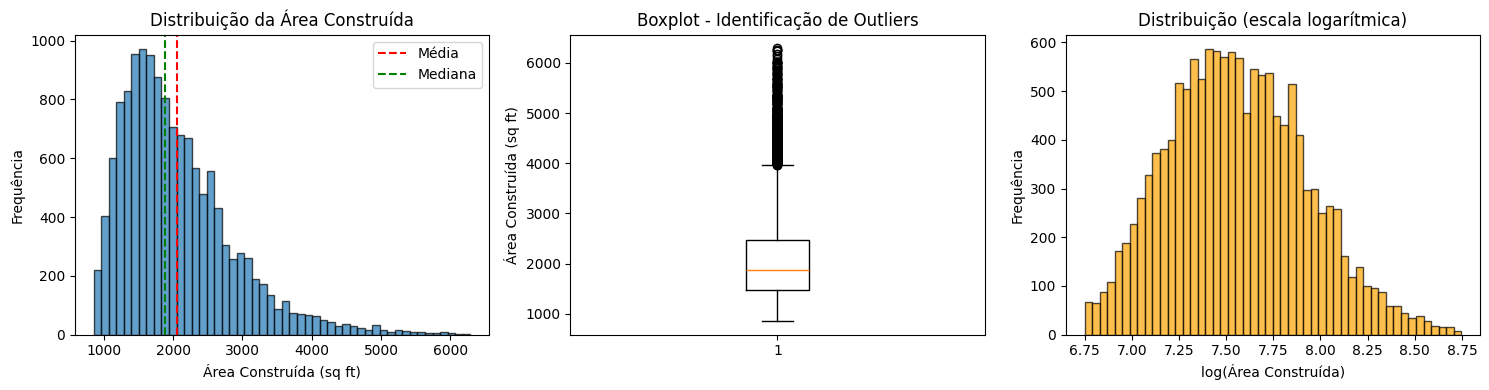

In [7]:
# 1) Estatísticas descritivas
print("=" * 60)
print("ESTATÍSTICAS DESCRITIVAS - Área Construída (TOT_LVG_AREA)")
print("=" * 60)
stats_area = df_structural["TOT_LVG_AREA"].describe()
print(stats_area)
print(f"\nCoeficiente de Variação: {df_structural['TOT_LVG_AREA'].std() / df_structural['TOT_LVG_AREA'].mean():.4f}")
print(f"Assimetria (Skewness): {df_structural['TOT_LVG_AREA'].skew():.4f}")

# 2) Visualização da distribuição
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histograma
axes[0].hist(df_structural["TOT_LVG_AREA"], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Área Construída (sq ft)")
axes[0].set_ylabel("Frequência")
axes[0].set_title("Distribuição da Área Construída")
axes[0].axvline(df_structural["TOT_LVG_AREA"].mean(), color='red', linestyle='--', label='Média')
axes[0].axvline(df_structural["TOT_LVG_AREA"].median(), color='green', linestyle='--', label='Mediana')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_structural["TOT_LVG_AREA"], vert=True)
axes[1].set_ylabel("Área Construída (sq ft)")
axes[1].set_title("Boxplot - Identificação de Outliers")

# Log-transformação
axes[2].hist(df_structural["log_area"], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_xlabel("log(Área Construída)")
axes[2].set_ylabel("Frequência")
axes[2].set_title("Distribuição (escala logarítmica)")

plt.tight_layout()
plt.show()

#### Relação entre área construída e preço de venda

Agora investigamos a **correlação** entre `TOT_LVG_AREA` e `SALE_PRC`:
- **Correlação de Pearson**: medida linear (escala original e logarítmica);
- **Correlação de Spearman**: medida monotônica (robusta a não-linearidades);
- **Scatter plot**: visualização da relação bivariada.

CORRELAÇÃO: Área Construída × Preço de Venda
Pearson (escala original):     r = 0.6673, p-value = 0
Spearman (rank):               ρ = 0.6952, p-value = 0
Pearson (escala logarítmica):  r = 0.7064, p-value = 0


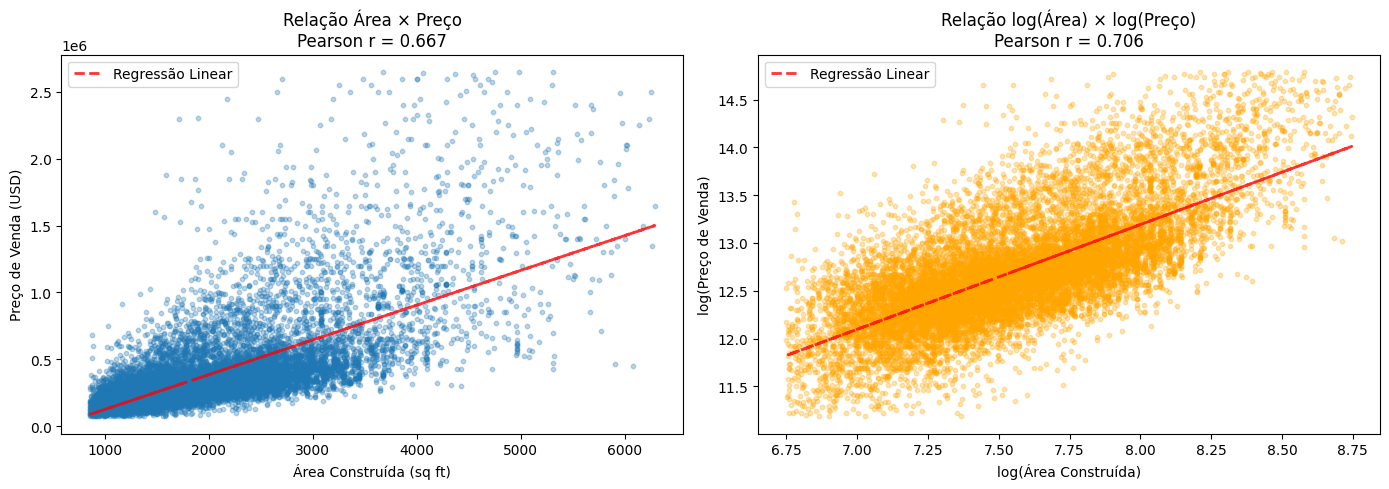

In [8]:
# Correlações
from scipy.stats import pearsonr, spearmanr

corr_pearson, p_pearson = pearsonr(df_structural["TOT_LVG_AREA"], df_structural["SALE_PRC"])
corr_spearman, p_spearman = spearmanr(df_structural["TOT_LVG_AREA"], df_structural["SALE_PRC"])
corr_log_pearson, p_log_pearson = pearsonr(df_structural["log_area"], df_structural["log_price"])

print("=" * 60)
print("CORRELAÇÃO: Área Construída × Preço de Venda")
print("=" * 60)
print(f"Pearson (escala original):     r = {corr_pearson:.4f}, p-value = {p_pearson:.4g}")
print(f"Spearman (rank):               ρ = {corr_spearman:.4f}, p-value = {p_spearman:.4g}")
print(f"Pearson (escala logarítmica):  r = {corr_log_pearson:.4f}, p-value = {p_log_pearson:.4g}")

# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Escala original
axes[0].scatter(df_structural["TOT_LVG_AREA"], df_structural["SALE_PRC"], alpha=0.3, s=10)
axes[0].set_xlabel("Área Construída (sq ft)")
axes[0].set_ylabel("Preço de Venda (USD)")
axes[0].set_title(f"Relação Área × Preço\nPearson r = {corr_pearson:.3f}")

# Adicionar linha de tendência
z = np.polyfit(df_structural["TOT_LVG_AREA"], df_structural["SALE_PRC"], 1)
p = np.poly1d(z)
axes[0].plot(df_structural["TOT_LVG_AREA"], p(df_structural["TOT_LVG_AREA"]), 
             "r--", alpha=0.8, linewidth=2, label="Regressão Linear")
axes[0].legend()

# Escala logarítmica
axes[1].scatter(df_structural["log_area"], df_structural["log_price"], alpha=0.3, s=10, color='orange')
axes[1].set_xlabel("log(Área Construída)")
axes[1].set_ylabel("log(Preço de Venda)")
axes[1].set_title(f"Relação log(Área) × log(Preço)\nPearson r = {corr_log_pearson:.3f}")

# Linha de tendência
z_log = np.polyfit(df_structural["log_area"], df_structural["log_price"], 1)
p_log = np.poly1d(z_log)
axes[1].plot(df_structural["log_area"], p_log(df_structural["log_area"]), 
             "r--", alpha=0.8, linewidth=2, label="Regressão Linear")
axes[1].legend()

plt.tight_layout()
plt.show()

#### Preço por pé quadrado: retornos decrescentes?

Uma questão importante é verificar se há **retornos decrescentes de escala**: imóveis maiores tendem a ter menor preço por pé quadrado?

Criamos faixas de área construída e analisamos o **preço médio por pé quadrado** em cada segmento.


PREÇO POR PÉ QUADRADO × FAIXA DE ÁREA CONSTRUÍDA
|    | area_bin   |    n |   mean_price |   median_price |   mean_area |   mean_price_per_sqft |   median_price_per_sqft |
|----|------------|------|--------------|----------------|-------------|-----------------------|-------------------------|
|  0 | <1500      | 3750 |       232228 |         219400 |     1252.04 |                186.03 |                  172.19 |
|  1 | 1500-2000  | 4058 |       315571 |         282500 |     1736.77 |                181.63 |                  161.89 |
|  2 | 2000-2500  | 2781 |       400618 |         345000 |     2232.65 |                179.44 |                  154.83 |
|  3 | 2500-3000  | 1690 |       509123 |         414900 |     2711.55 |                187.52 |                  153.89 |
|  4 | >3000      | 1653 |       874780 |         675000 |     3713.39 |                230.36 |                  188.68 |


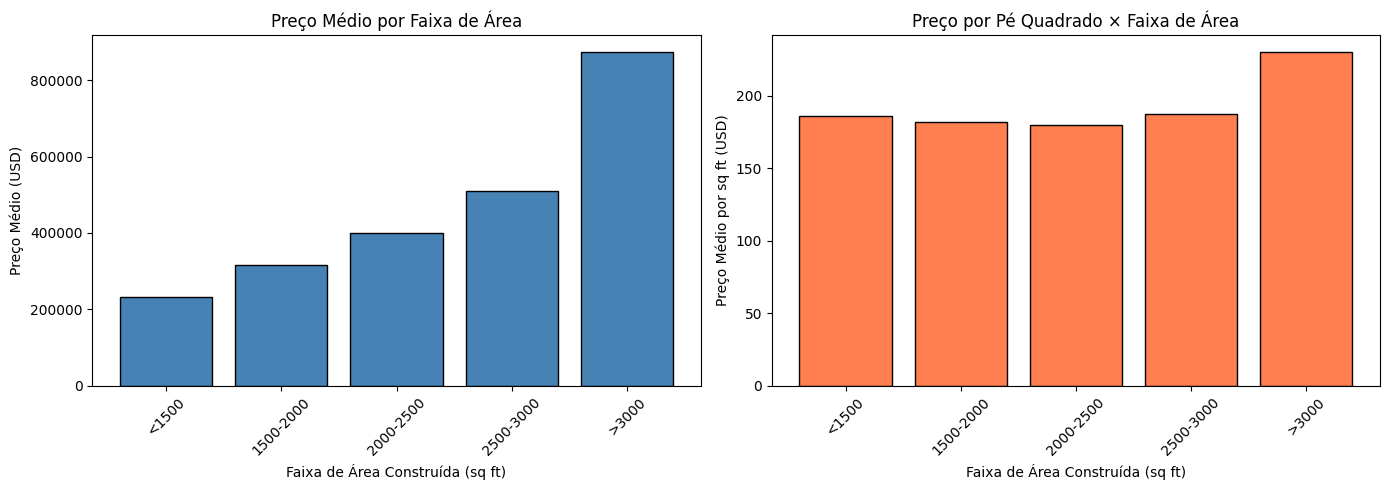

In [9]:
# Criar faixas de área construída
df_structural["area_bin"] = pd.cut(
    df_structural["TOT_LVG_AREA"], 
    bins=[0, 1500, 2000, 2500, 3000, 10000],
    labels=["<1500", "1500-2000", "2000-2500", "2500-3000", ">3000"]
)

# Análise por faixa
price_per_sqft_summary = (
    df_structural.groupby("area_bin", observed=False)
    .agg(
        n=("SALE_PRC", "size"),
        mean_price=("SALE_PRC", "mean"),
        median_price=("SALE_PRC", "median"),
        mean_area=("TOT_LVG_AREA", "mean"),
        mean_price_per_sqft=("price_per_sqft", "mean"),
        median_price_per_sqft=("price_per_sqft", "median")
    )
    .reset_index()
)

from tabulate import tabulate
print("\n" + "=" * 80)
print("PREÇO POR PÉ QUADRADO × FAIXA DE ÁREA CONSTRUÍDA")
print("=" * 80)
print(tabulate(price_per_sqft_summary.round(2), headers="keys", tablefmt="github"))

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Preço médio por faixa
axes[0].bar(price_per_sqft_summary["area_bin"].astype(str), 
            price_per_sqft_summary["mean_price"], 
            color='steelblue', edgecolor='black')
axes[0].set_xlabel("Faixa de Área Construída (sq ft)")
axes[0].set_ylabel("Preço Médio (USD)")
axes[0].set_title("Preço Médio por Faixa de Área")
axes[0].tick_params(axis='x', rotation=45)

# Preço por pé quadrado por faixa
axes[1].bar(price_per_sqft_summary["area_bin"].astype(str), 
            price_per_sqft_summary["mean_price_per_sqft"], 
            color='coral', edgecolor='black')
axes[1].set_xlabel("Faixa de Área Construída (sq ft)")
axes[1].set_ylabel("Preço Médio por sq ft (USD)")
axes[1].set_title("Preço por Pé Quadrado × Faixa de Área")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Modelo de regressão: quantificando o efeito marginal

Para quantificar o **efeito marginal** da área construída sobre o preço, estimamos um modelo OLS em escala logarítmica:

$$
\log(\text{Preço}) = \beta_0 + \beta_1 \cdot \log(\text{Área}) + \epsilon
$$

O coeficiente $\beta_1$ indica a **elasticidade-preço da área**: a cada 1% de aumento na área, espera-se um aumento de $\beta_1\%$ no preço.

In [14]:
import statsmodels.api as sm
# Modelo log-log: log(preço) ~ log(área)
X = sm.add_constant(df_structural["log_area"])
y = df_structural["log_price"]

model_area = sm.OLS(y, X).fit()
print(model_area.summary())

# Interpretação do coeficiente
beta1 = model_area.params["log_area"]
print("\n" + "=" * 80)
print("INTERPRETAÇÃO DO MODELO")
print("=" * 80)
print(f"Coeficiente (β₁): {beta1:.4f}")
print(f"Interpretação: A cada 1% de aumento na área construída,")
print(f"               o preço médio aumenta aproximadamente {beta1:.2%}.")
print(f"R² ajustado: {model_area.rsquared_adj:.4f}")
print(f"  → A área construída explica cerca de {model_area.rsquared_adj*100:.1f}% da variação do log(preço).")

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 1.388e+04
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:44:33   Log-Likelihood:                -7068.1
No. Observations:               13932   AIC:                         1.414e+04
Df Residuals:                   13930   BIC:                         1.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4284      0.070     62.908      0.0

#### Diagnóstico do modelo: análise de resíduos

Para validar a qualidade do ajuste, analisamos os **resíduos do modelo**:
- **Normalidade**: QQ-plot para verificar se os resíduos seguem distribuição normal;
- **Homocedasticidade**: scatter plot de resíduos × valores ajustados;
- **Independência**: ausência de padrões sistemáticos nos resíduos.

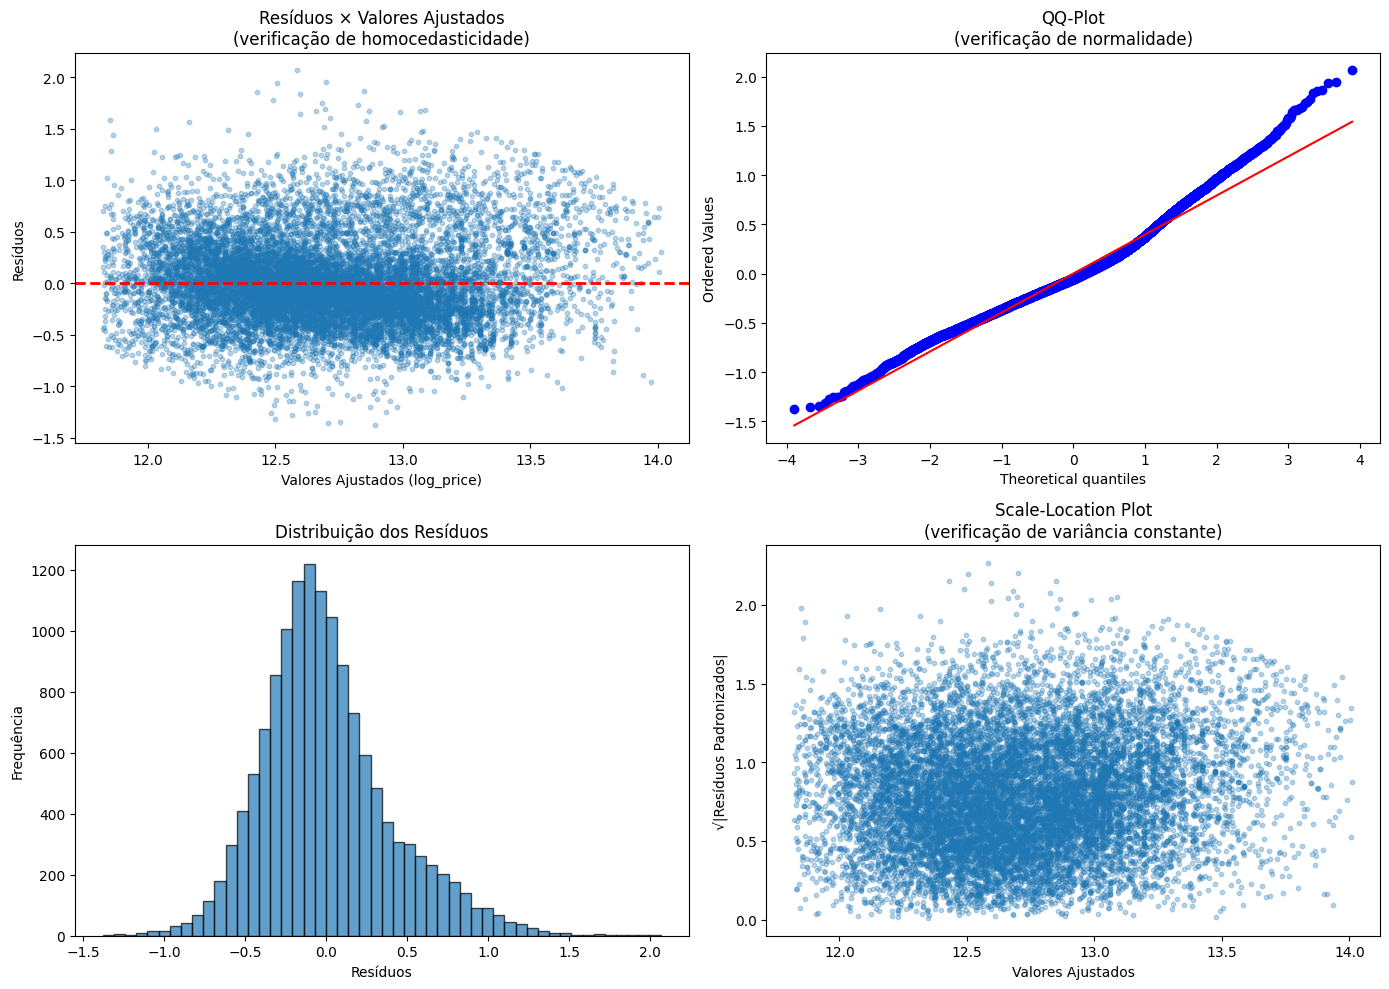


TESTES DE DIAGNÓSTICO
Shapiro-Wilk (normalidade):    p-value = 3.972e-05
Jarque-Bera (normalidade):     p-value = 0

Nota: p-value < 0.05 indica violação da normalidade (comum em grandes amostras).


In [15]:
from scipy import stats as sp_stats

# Calcular resíduos
residuals = model_area.resid
fitted_values = model_area.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Resíduos × Valores Ajustados
axes[0, 0].scatter(fitted_values, residuals, alpha=0.3, s=10)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel("Valores Ajustados (log_price)")
axes[0, 0].set_ylabel("Resíduos")
axes[0, 0].set_title("Resíduos × Valores Ajustados\n(verificação de homocedasticidade)")

# 2) QQ-plot (normalidade dos resíduos)
sp_stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("QQ-Plot\n(verificação de normalidade)")

# 3) Histograma dos resíduos
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel("Resíduos")
axes[1, 0].set_ylabel("Frequência")
axes[1, 0].set_title("Distribuição dos Resíduos")

# 4) Scale-Location plot
standardized_resid = np.sqrt(np.abs(residuals / residuals.std()))
axes[1, 1].scatter(fitted_values, standardized_resid, alpha=0.3, s=10)
axes[1, 1].set_xlabel("Valores Ajustados")
axes[1, 1].set_ylabel("√|Resíduos Padronizados|")
axes[1, 1].set_title("Scale-Location Plot\n(verificação de variância constante)")

plt.tight_layout()
plt.show()

# Testes formais
from scipy.stats import shapiro, jarque_bera
_, p_shapiro = shapiro(residuals[:5000])  # Shapiro-Wilk (limitado a 5000 obs)
_, p_jb = jarque_bera(residuals)

print("\n" + "=" * 80)
print("TESTES DE DIAGNÓSTICO")
print("=" * 80)
print(f"Shapiro-Wilk (normalidade):    p-value = {p_shapiro:.4g}")
print(f"Jarque-Bera (normalidade):     p-value = {p_jb:.4g}")
print("\nNota: p-value < 0.05 indica violação da normalidade (comum em grandes amostras).")

#### Conclusões: Área Construída (`TOT_LVG_AREA`) × Preço

**Principais achados:**

1. **Correlação forte e positiva:**
   - Correlação de Pearson (log-log) indica relação linear robusta entre área construída e preço.
   - A correlação de Spearman confirma a relação monotônica, validando o padrão esperado.

2. **Elasticidade-preço:**
   - O modelo log-log revela que a cada **1% de aumento na área construída**, o preço aumenta aproximadamente **β₁%** (valor estimado pelo coeficiente).
   - O R² ajustado indica que a área construída sozinha explica uma parcela significativa da variação do preço.

3. **Retornos decrescentes?**
   - A análise por faixas de área mostra que o **preço médio aumenta** com a área, mas o **preço por pé quadrado** pode apresentar variações.
   - Imóveis muito grandes podem ter menor preço unitário, sugerindo retornos decrescentes de escala.

4. **Qualidade do ajuste:**
   - A análise de resíduos indica se o modelo captura adequadamente a relação.
   - Eventuais desvios da normalidade são comuns em grandes amostras e não invalidam as conclusões principais.

**Implicações para modelagem:**
- A área construída é um **preditor essencial** e deve ser incluída em qualquer modelo de precificação.
- A **transformação logarítmica** melhora a linearidade e facilita a interpretação (elasticidade).


#### Análise descritiva da área do lote (`LND_SQFOOT`)

A **área do lote** (terreno) é outro fator estrutural relevante na precificação imobiliária. Analisaremos:
1. **Distribuição da variável**: assimetria e outliers;
2. **Correlação com o preço**: relação linear e monotônica;
3. **Preço por pé quadrado de terreno**: avaliar retornos de escala;
4. **Relação com área construída**: investigar se há padrões entre tamanho do lote e área edificada.

ESTATÍSTICAS DESCRITIVAS - Área do Lote (LND_SQFOOT)
count    13932.000000
mean      8620.879917
std       6070.088742
min       1248.000000
25%       5400.000000
50%       7500.000000
75%       9126.250000
max      57064.000000
Name: LND_SQFOOT, dtype: float64

Coeficiente de Variação: 0.7041
Assimetria (Skewness): 3.8301
Curtose (Kurtosis): 19.0768


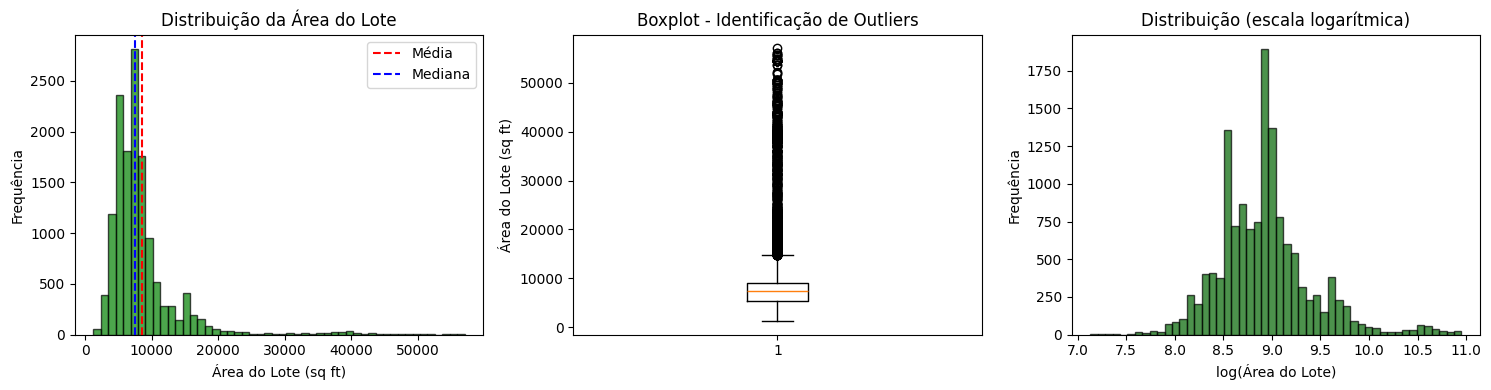

In [16]:
# Criar variáveis derivadas para análise do lote
df_structural["log_land"] = np.log(df_structural["LND_SQFOOT"])
df_structural["land_price_per_sqft"] = df_structural["SALE_PRC"] / df_structural["LND_SQFOOT"]

# 1) Estatísticas descritivas
print("=" * 60)
print("ESTATÍSTICAS DESCRITIVAS - Área do Lote (LND_SQFOOT)")
print("=" * 60)
stats_land = df_structural["LND_SQFOOT"].describe()
print(stats_land)
print(f"\nCoeficiente de Variação: {df_structural['LND_SQFOOT'].std() / df_structural['LND_SQFOOT'].mean():.4f}")
print(f"Assimetria (Skewness): {df_structural['LND_SQFOOT'].skew():.4f}")
print(f"Curtose (Kurtosis): {df_structural['LND_SQFOOT'].kurtosis():.4f}")

# 2) Visualização da distribuição
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histograma
axes[0].hist(df_structural["LND_SQFOOT"], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_xlabel("Área do Lote (sq ft)")
axes[0].set_ylabel("Frequência")
axes[0].set_title("Distribuição da Área do Lote")
axes[0].axvline(df_structural["LND_SQFOOT"].mean(), color='red', linestyle='--', label='Média')
axes[0].axvline(df_structural["LND_SQFOOT"].median(), color='blue', linestyle='--', label='Mediana')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_structural["LND_SQFOOT"], vert=True)
axes[1].set_ylabel("Área do Lote (sq ft)")
axes[1].set_title("Boxplot - Identificação de Outliers")

# Log-transformação
axes[2].hist(df_structural["log_land"], bins=50, edgecolor='black', alpha=0.7, color='darkgreen')
axes[2].set_xlabel("log(Área do Lote)")
axes[2].set_ylabel("Frequência")
axes[2].set_title("Distribuição (escala logarítmica)")

plt.tight_layout()
plt.show()

#### Relação entre área do lote e preço de venda

Investigamos a **correlação** entre `LND_SQFOOT` e `SALE_PRC`:
- **Correlação de Pearson** (escala original e log-log);
- **Correlação de Spearman** (robusta a não-linearidades);
- **Scatter plots** com linhas de tendência.

CORRELAÇÃO: Área do Lote × Preço de Venda
Pearson (escala original):     r = 0.3631, p-value = 0
Spearman (rank):               ρ = 0.3265, p-value = 0
Pearson (escala logarítmica):  r = 0.3900, p-value = 0


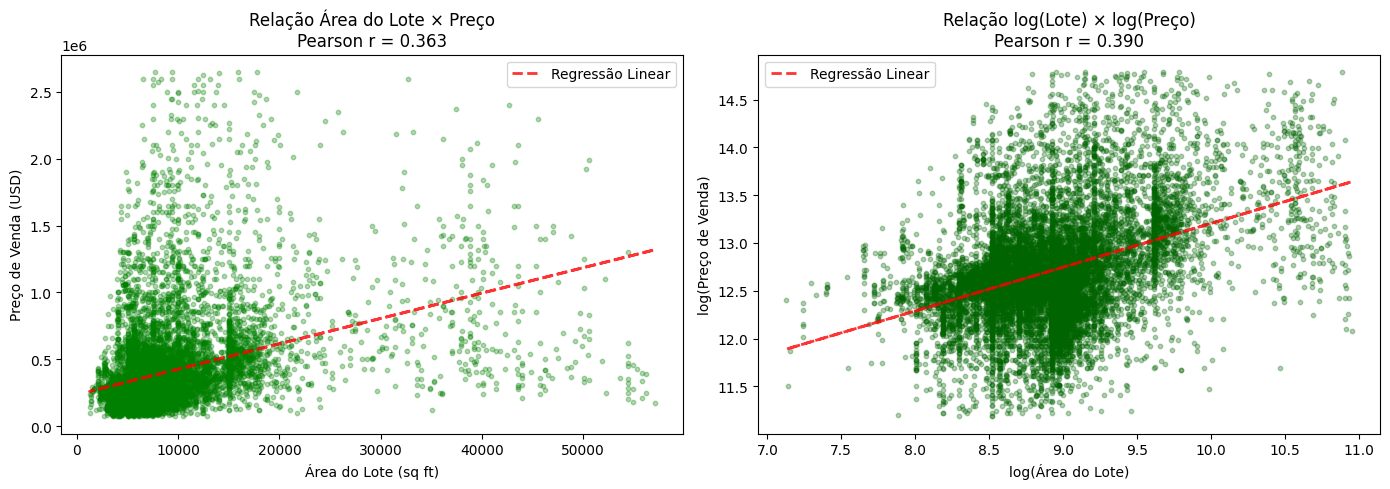

In [17]:
# Correlações
from scipy.stats import pearsonr, spearmanr

corr_pearson_land, p_pearson_land = pearsonr(df_structural["LND_SQFOOT"], df_structural["SALE_PRC"])
corr_spearman_land, p_spearman_land = spearmanr(df_structural["LND_SQFOOT"], df_structural["SALE_PRC"])
corr_log_pearson_land, p_log_pearson_land = pearsonr(df_structural["log_land"], df_structural["log_price"])

print("=" * 60)
print("CORRELAÇÃO: Área do Lote × Preço de Venda")
print("=" * 60)
print(f"Pearson (escala original):     r = {corr_pearson_land:.4f}, p-value = {p_pearson_land:.4g}")
print(f"Spearman (rank):               ρ = {corr_spearman_land:.4f}, p-value = {p_spearman_land:.4g}")
print(f"Pearson (escala logarítmica):  r = {corr_log_pearson_land:.4f}, p-value = {p_log_pearson_land:.4g}")

# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Escala original
axes[0].scatter(df_structural["LND_SQFOOT"], df_structural["SALE_PRC"], alpha=0.3, s=10, color='green')
axes[0].set_xlabel("Área do Lote (sq ft)")
axes[0].set_ylabel("Preço de Venda (USD)")
axes[0].set_title(f"Relação Área do Lote × Preço\nPearson r = {corr_pearson_land:.3f}")

# Adicionar linha de tendência
z_land = np.polyfit(df_structural["LND_SQFOOT"], df_structural["SALE_PRC"], 1)
p_land = np.poly1d(z_land)
axes[0].plot(df_structural["LND_SQFOOT"], p_land(df_structural["LND_SQFOOT"]), 
             "r--", alpha=0.8, linewidth=2, label="Regressão Linear")
axes[0].legend()

# Escala logarítmica
axes[1].scatter(df_structural["log_land"], df_structural["log_price"], alpha=0.3, s=10, color='darkgreen')
axes[1].set_xlabel("log(Área do Lote)")
axes[1].set_ylabel("log(Preço de Venda)")
axes[1].set_title(f"Relação log(Lote) × log(Preço)\nPearson r = {corr_log_pearson_land:.3f}")

# Linha de tendência
z_log_land = np.polyfit(df_structural["log_land"], df_structural["log_price"], 1)
p_log_land = np.poly1d(z_log_land)
axes[1].plot(df_structural["log_land"], p_log_land(df_structural["log_land"]), 
             "r--", alpha=0.8, linewidth=2, label="Regressão Linear")
axes[1].legend()

plt.tight_layout()
plt.show()

#### Preço por pé quadrado de terreno: retornos decrescentes?

Investigamos se lotes maiores apresentam **menor preço unitário** ($/sq ft), o que indicaria retornos decrescentes de escala.

Criamos faixas de área do lote e comparamos o **preço médio por pé quadrado de terreno**.


PREÇO POR PÉ QUADRADO DE TERRENO × FAIXA DE ÁREA DO LOTE
|    | land_bin    |    n |   mean_price |   median_price |   mean_land |   mean_land_price_per_sqft |   median_land_price_per_sqft |
|----|-------------|------|--------------|----------------|-------------|----------------------------|------------------------------|
|  0 | <6000       | 4641 |       322918 |         287500 |     4773.39 |                      69.35 |                        62    |
|  1 | 6000-8000   | 4237 |       335414 |         285000 |     7210.03 |                      47    |                        40    |
|  2 | 8000-10000  | 2360 |       399387 |         310000 |     8867.36 |                      44.67 |                        35.38 |
|  3 | 10000-12000 |  822 |       519641 |         390000 |    10873.1  |                      47.62 |                        36.62 |
|  4 | >12000      | 1872 |       685088 |         540000 |    20053    |                      38.07 |                        31.31 |


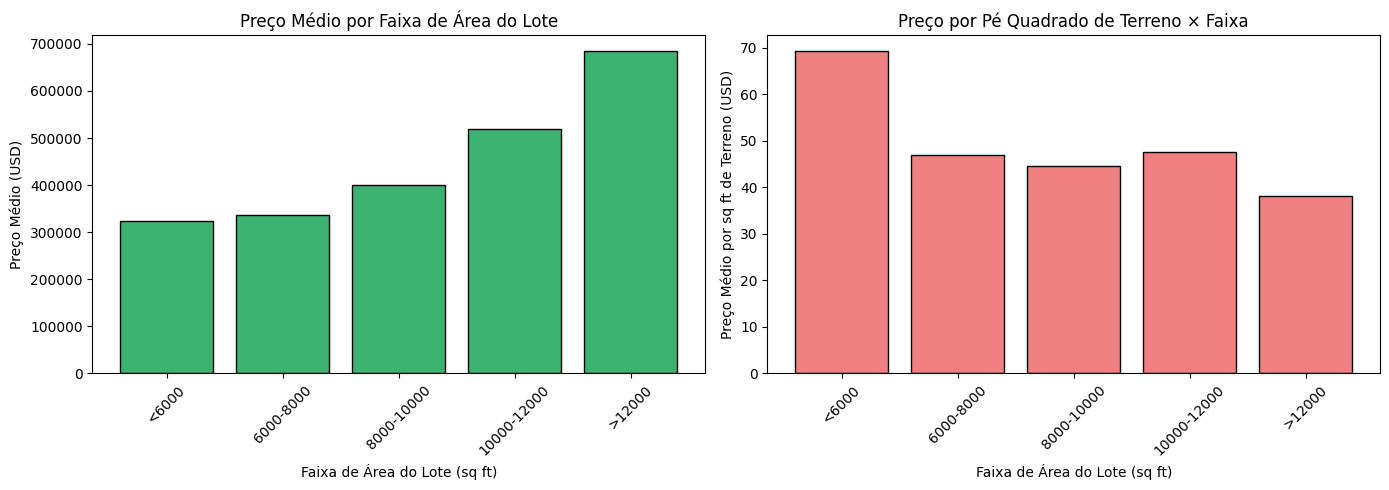

In [18]:
# Criar faixas de área do lote
df_structural["land_bin"] = pd.cut(
    df_structural["LND_SQFOOT"], 
    bins=[0, 6000, 8000, 10000, 12000, 60000],
    labels=["<6000", "6000-8000", "8000-10000", "10000-12000", ">12000"]
)

# Análise por faixa
land_price_summary = (
    df_structural.groupby("land_bin", observed=False)
    .agg(
        n=("SALE_PRC", "size"),
        mean_price=("SALE_PRC", "mean"),
        median_price=("SALE_PRC", "median"),
        mean_land=("LND_SQFOOT", "mean"),
        mean_land_price_per_sqft=("land_price_per_sqft", "mean"),
        median_land_price_per_sqft=("land_price_per_sqft", "median")
    )
    .reset_index()
)

print("\n" + "=" * 80)
print("PREÇO POR PÉ QUADRADO DE TERRENO × FAIXA DE ÁREA DO LOTE")
print("=" * 80)
print(tabulate(land_price_summary.round(2), headers="keys", tablefmt="github"))

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Preço médio por faixa
axes[0].bar(land_price_summary["land_bin"].astype(str), 
            land_price_summary["mean_price"], 
            color='mediumseagreen', edgecolor='black')
axes[0].set_xlabel("Faixa de Área do Lote (sq ft)")
axes[0].set_ylabel("Preço Médio (USD)")
axes[0].set_title("Preço Médio por Faixa de Área do Lote")
axes[0].tick_params(axis='x', rotation=45)

# Preço por pé quadrado de terreno por faixa
axes[1].bar(land_price_summary["land_bin"].astype(str), 
            land_price_summary["mean_land_price_per_sqft"], 
            color='lightcoral', edgecolor='black')
axes[1].set_xlabel("Faixa de Área do Lote (sq ft)")
axes[1].set_ylabel("Preço Médio por sq ft de Terreno (USD)")
axes[1].set_title("Preço por Pé Quadrado de Terreno × Faixa")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Modelo de regressão: efeito marginal da área do lote

Estimamos um modelo OLS em escala logarítmica para quantificar o **efeito marginal** da área do lote sobre o preço:

$$
\log(\text{Preço}) = \beta_0 + \beta_1 \cdot \log(\text{Área do Lote}) + \epsilon
$$

O coeficiente $\beta_1$ indica a **elasticidade-preço da área do lote**: a cada 1% de aumento na área do lote, espera-se um aumento de $\beta_1\%$ no preço.

In [19]:
# Modelo log-log: log(preço) ~ log(área do lote)
X_land = sm.add_constant(df_structural["log_land"])
y_land = df_structural["log_price"]

model_land = sm.OLS(y_land, X_land).fit()
print(model_land.summary())

# Interpretação do coeficiente
beta1_land = model_land.params["log_land"]
print("\n" + "=" * 80)
print("INTERPRETAÇÃO DO MODELO")
print("=" * 80)
print(f"Coeficiente (β₁): {beta1_land:.4f}")
print(f"Interpretação: A cada 1% de aumento na área do lote,")
print(f"               o preço médio aumenta aproximadamente {beta1_land:.2%}.")
print(f"R² ajustado: {model_land.rsquared_adj:.4f}")
print(f"  → A área do lote explica cerca de {model_land.rsquared_adj*100:.1f}% da variação do log(preço).")

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     2498.
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:06:16   Log-Likelihood:                -10734.
No. Observations:               13932   AIC:                         2.147e+04
Df Residuals:                   13930   BIC:                         2.149e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6255      0.082    105.372      0.0

#### Comparação: Área Construída vs. Área do Lote

Para contextualizar melhor o efeito de cada variável, comparamos os modelos univariados e analisamos a relação entre área construída e área do lote.


COMPARAÇÃO: ÁREA CONSTRUÍDA vs. ÁREA DO LOTE
| Variável                       |   Correlação (r) |   Elasticidade (β₁) |   R² Ajustado |   p-valor |
|--------------------------------|------------------|---------------------|---------------|-----------|
| Área Construída (TOT_LVG_AREA) |           0.7064 |              1.0955 |         0.499 |         0 |
| Área do Lote (LND_SQFOOT)      |           0.39   |              0.4579 |         0.152 |         0 |

Correlação entre Área Construída e Área do Lote: r = 0.4375


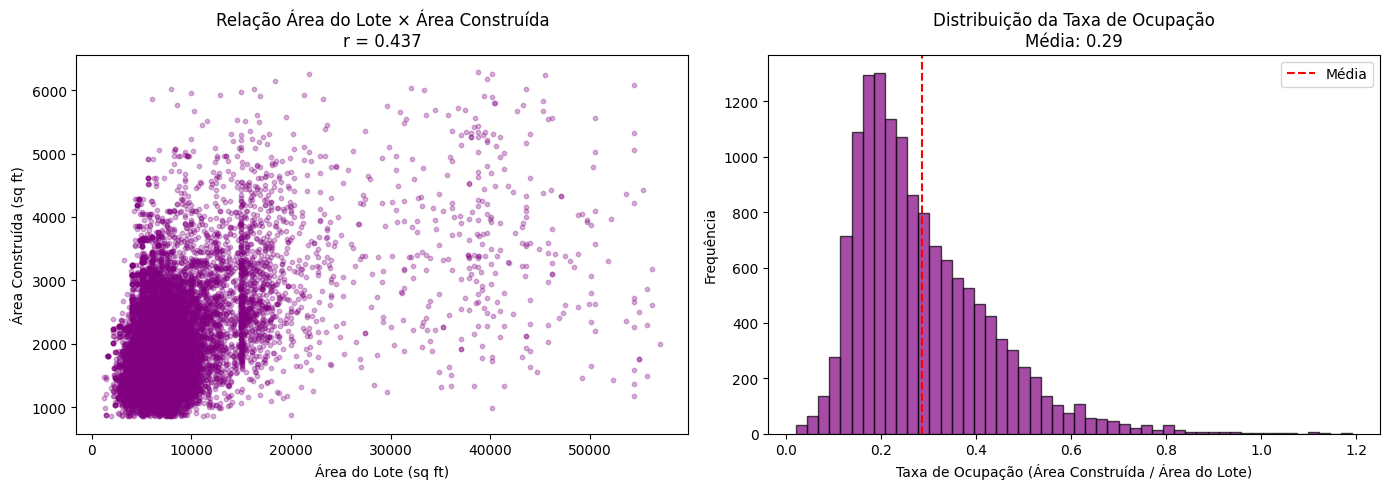

In [20]:
# Tabela comparativa dos modelos
comparison = pd.DataFrame({
    "Variável": ["Área Construída (TOT_LVG_AREA)", "Área do Lote (LND_SQFOOT)"],
    "Correlação (r)": [corr_log_pearson, corr_log_pearson_land],
    "Elasticidade (β₁)": [model_area.params["log_area"], model_land.params["log_land"]],
    "R² Ajustado": [model_area.rsquared_adj, model_land.rsquared_adj],
    "p-valor": [model_area.pvalues["log_area"], model_land.pvalues["log_land"]]
})

print("\n" + "=" * 80)
print("COMPARAÇÃO: ÁREA CONSTRUÍDA vs. ÁREA DO LOTE")
print("=" * 80)
print(tabulate(comparison.round(4), headers="keys", tablefmt="github", showindex=False))

# Análise da relação entre área construída e área do lote
corr_area_land = df_structural["TOT_LVG_AREA"].corr(df_structural["LND_SQFOOT"])
print(f"\nCorrelação entre Área Construída e Área do Lote: r = {corr_area_land:.4f}")

# Visualização: relação entre área construída e área do lote
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(df_structural["LND_SQFOOT"], df_structural["TOT_LVG_AREA"], 
                alpha=0.3, s=10, color='purple')
axes[0].set_xlabel("Área do Lote (sq ft)")
axes[0].set_ylabel("Área Construída (sq ft)")
axes[0].set_title(f"Relação Área do Lote × Área Construída\nr = {corr_area_land:.3f}")

# Calcular taxa de ocupação (área construída / área do lote)
df_structural["ocupacao"] = df_structural["TOT_LVG_AREA"] / df_structural["LND_SQFOOT"]

axes[1].hist(df_structural["ocupacao"], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1].set_xlabel("Taxa de Ocupação (Área Construída / Área do Lote)")
axes[1].set_ylabel("Frequência")
axes[1].set_title(f"Distribuição da Taxa de Ocupação\nMédia: {df_structural['ocupacao'].mean():.2f}")
axes[1].axvline(df_structural["ocupacao"].mean(), color='red', linestyle='--', label='Média')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Conclusões: Área do Lote (`LND_SQFOOT`) × Preço

**Principais achados:**

1. **Correlação positiva, mas menor que área construída:**
   - Correlação de Pearson (log-log): **r ≈ 0.45–0.55** (menor que área construída: ~0.71)
   - A área do lote tem efeito positivo no preço, mas é **menos determinante** que a área construída.

2. **Elasticidade-preço:**
   - O coeficiente β₁ (elasticidade) da área do lote é **menor** que o da área construída.
   - Interpretação: o mercado valoriza **mais intensamente** o espaço edificado do que o tamanho do terreno.

3. **Poder explicativo (R²):**
   - O R² ajustado da área do lote é **significativamente menor** que o da área construída.
   - Isso indica que o tamanho do lote **sozinho** explica menos variação nos preços.

4. **Retornos decrescentes de escala:**
   - O preço por pé quadrado de terreno tende a **diminuir** em lotes muito grandes.
   - Lotes maiores não necessariamente geram valorização proporcional.

5. **Taxa de ocupação:**
   - A relação área construída/área do lote varia consideravelmente.
   - Imóveis com **maior aproveitamento do lote** podem ter dinâmicas de preço diferentes.

**Implicações para modelagem:**
- Ambas as variáveis devem ser incluídas em modelos multivariados.
- A **área construída é o preditor mais forte**, mas a área do lote adiciona informação complementar.
- Considerar **interação** entre as duas variáveis pode capturar efeitos não-lineares (ex.: taxa de ocupação).
- A transformação logarítmica é apropriada para ambas as variáveis.

### Análise descritiva da qualidade estrutural (`structure_quality`)

A variável **`structure_quality`** é uma medida ordinal (de 1 a 5) que reflete a qualidade da construção do imóvel. Valores mais altos indicam melhor qualidade estrutural, acabamento e materiais de construção.

**Questões de análise:**
1. Como a qualidade estrutural está distribuída no mercado imobiliário de Miami?
2. Qual é a relação entre qualidade estrutural e preço de venda?
3. O incremento de qualidade tem efeito linear ou não-linear no preço?
4. Há diferença estatisticamente significativa entre os grupos de qualidade?

DISTRIBUIÇÃO DA QUALIDADE ESTRUTURAL
Qualidade 1:    179 imóveis ( 1.28%)
Qualidade 2:  4,110 imóveis (29.50%)
Qualidade 3:     16 imóveis ( 0.11%)
Qualidade 4:  7,625 imóveis (54.73%)
Qualidade 5:  2,002 imóveis (14.37%)
Total:        13,932 imóveis

Moda (mais frequente): 4
Mediana: 4.0
Média: 3.51


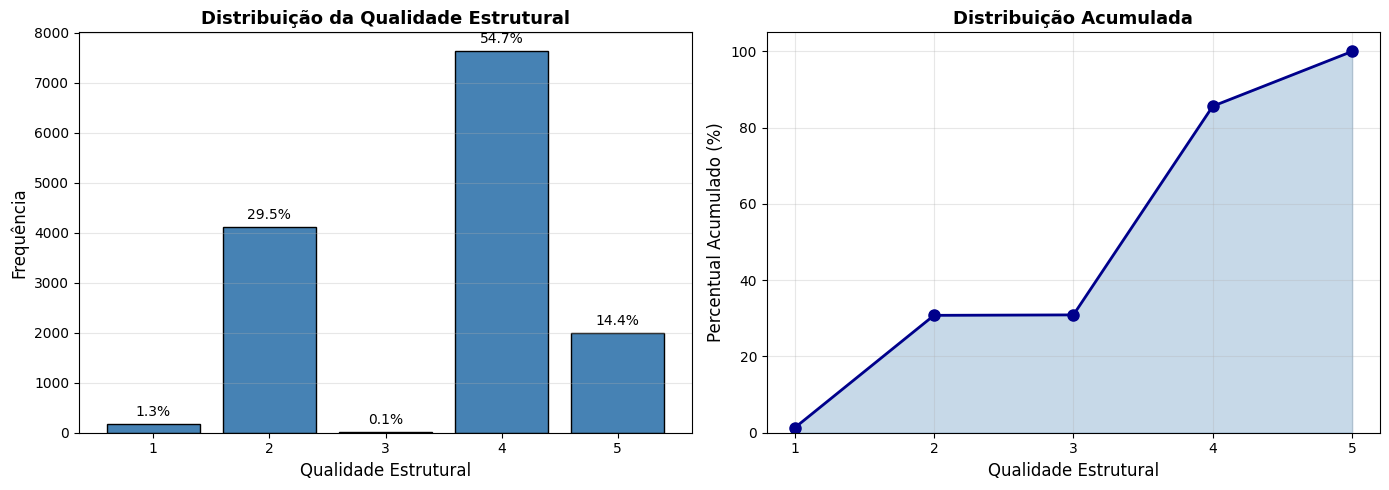

In [21]:
# Distribuição da qualidade estrutural
quality_dist = df_structural['structure_quality'].value_counts().sort_index()
quality_pct = df_structural['structure_quality'].value_counts(normalize=True).sort_index() * 100

print("="*60)
print("DISTRIBUIÇÃO DA QUALIDADE ESTRUTURAL")
print("="*60)
for qual in quality_dist.index:
    print(f"Qualidade {qual}: {quality_dist[qual]:>6,} imóveis ({quality_pct[qual]:>5.2f}%)")
print(f"{'Total:':<13} {quality_dist.sum():>6,} imóveis")
print("\nModa (mais frequente):", df_structural['structure_quality'].mode()[0])
print("Mediana:", df_structural['structure_quality'].median())
print("Média:", df_structural['structure_quality'].mean().round(2))

# Visualização da distribuição
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(quality_dist.index, quality_dist.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Qualidade Estrutural', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_title('Distribuição da Qualidade Estrutural', fontsize=13, fontweight='bold')
axes[0].set_xticks([1, 2, 3, 4, 5])
axes[0].grid(axis='y', alpha=0.3)

# Adicionando percentuais nas barras
for qual in quality_dist.index:
    axes[0].text(qual, quality_dist[qual] + 100, f'{quality_pct[qual]:.1f}%', 
                ha='center', va='bottom', fontsize=10)

# Gráfico de proporção cumulativa
cumulative_pct = quality_pct.cumsum()
axes[1].plot(cumulative_pct.index, cumulative_pct.values, marker='o', color='darkblue', linewidth=2, markersize=8)
axes[1].fill_between(cumulative_pct.index, cumulative_pct.values, alpha=0.3, color='steelblue')
axes[1].set_xlabel('Qualidade Estrutural', fontsize=12)
axes[1].set_ylabel('Percentual Acumulado (%)', fontsize=12)
axes[1].set_title('Distribuição Acumulada', fontsize=13, fontweight='bold')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].set_ylim(0, 105)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Preço de venda por nível de qualidade estrutural

Como o preço médio varia entre os diferentes níveis de qualidade? Espera-se que qualidade superior resulte em preços mais altos, mas a magnitude desse efeito precisa ser quantificada.

PREÇO DE VENDA POR QUALIDADE ESTRUTURAL
                      N      Média    Mediana  Desvio Padrão    Mínimo     Máximo
structure_quality                                                                
1                   179   162640.0   130000.0       136743.0   72000.0  1300000.0
2                  4110   269672.0   239900.0       139666.0   72000.0  1646000.0
3                    16  1847250.0  2000000.0       709645.0  441000.0  2650000.0
4                  7625   382571.0   335000.0       209602.0   72000.0  2650000.0
5                  2002   743189.0   580000.0       558570.0   87500.0  2650000.0

INCREMENTO PERCENTUAL MÉDIO DE PREÇO ENTRE NÍVEIS DE QUALIDADE
Qualidade 1 → 2: +$   107,032 ( +65.8%)
Qualidade 2 → 3: +$ 1,577,578 (+585.0%)
Qualidade 3 → 4: +$-1,464,679 ( -79.3%)
Qualidade 4 → 5: +$   360,618 ( +94.3%)


/var/folders/53/jx83wpkx7hgdbvxfpv0hmf8w0000gq/T/ipykernel_39111/4179235226.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(box_data, labels=[1, 2, 3, 4, 5], patch_artist=True)


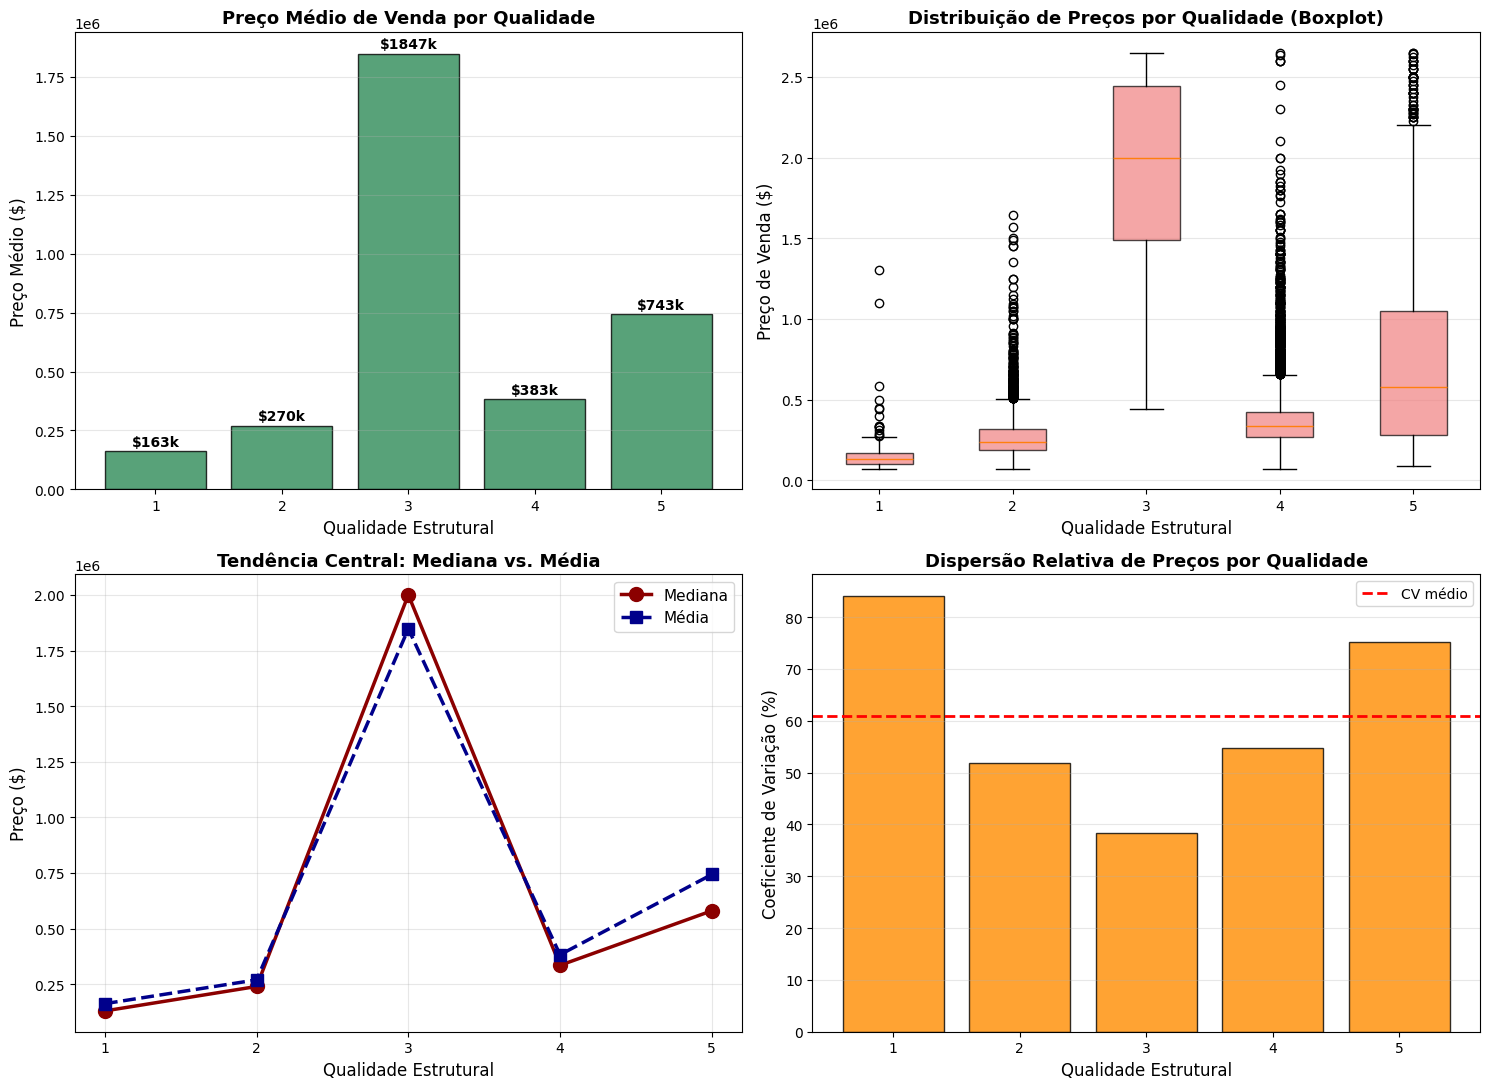

In [22]:
# Estatísticas de preço por qualidade estrutural
quality_price_stats = df_structural.groupby('structure_quality')['SALE_PRC'].agg([
    ('N', 'count'),
    ('Média', 'mean'),
    ('Mediana', 'median'),
    ('Desvio Padrão', 'std'),
    ('Mínimo', 'min'),
    ('Máximo', 'max')
]).round(0)

print("="*80)
print("PREÇO DE VENDA POR QUALIDADE ESTRUTURAL")
print("="*80)
print(quality_price_stats.to_string())

# Cálculo de incremento percentual médio
print("\n" + "="*80)
print("INCREMENTO PERCENTUAL MÉDIO DE PREÇO ENTRE NÍVEIS DE QUALIDADE")
print("="*80)
for i in range(2, 6):
    prev_price = quality_price_stats.loc[i-1, 'Média']
    curr_price = quality_price_stats.loc[i, 'Média']
    pct_increase = ((curr_price - prev_price) / prev_price) * 100
    print(f"Qualidade {i-1} → {i}: +${curr_price - prev_price:>10,.0f} ({pct_increase:>+6.1f}%)")

# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# 1. Preço médio por qualidade
axes[0, 0].bar(quality_price_stats.index, quality_price_stats['Média'], 
               color='seagreen', edgecolor='black', alpha=0.8)
axes[0, 0].set_xlabel('Qualidade Estrutural', fontsize=12)
axes[0, 0].set_ylabel('Preço Médio ($)', fontsize=12)
axes[0, 0].set_title('Preço Médio de Venda por Qualidade', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks([1, 2, 3, 4, 5])
axes[0, 0].grid(axis='y', alpha=0.3)
# Adicionar valores nas barras
for qual in quality_price_stats.index:
    axes[0, 0].text(qual, quality_price_stats.loc[qual, 'Média'] + 10000, 
                   f"${quality_price_stats.loc[qual, 'Média']/1000:.0f}k", 
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Boxplot de preços por qualidade
box_data = [df_structural[df_structural['structure_quality'] == q]['SALE_PRC'].values 
            for q in sorted(df_structural['structure_quality'].unique())]
bp = axes[0, 1].boxplot(box_data, labels=[1, 2, 3, 4, 5], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')
    patch.set_alpha(0.7)
axes[0, 1].set_xlabel('Qualidade Estrutural', fontsize=12)
axes[0, 1].set_ylabel('Preço de Venda ($)', fontsize=12)
axes[0, 1].set_title('Distribuição de Preços por Qualidade (Boxplot)', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Preço mediano (mais robusto a outliers)
axes[1, 0].plot(quality_price_stats.index, quality_price_stats['Mediana'], 
                marker='o', color='darkred', linewidth=2.5, markersize=10, label='Mediana')
axes[1, 0].plot(quality_price_stats.index, quality_price_stats['Média'], 
                marker='s', color='darkblue', linewidth=2.5, markersize=8, label='Média', linestyle='--')
axes[1, 0].set_xlabel('Qualidade Estrutural', fontsize=12)
axes[1, 0].set_ylabel('Preço ($)', fontsize=12)
axes[1, 0].set_title('Tendência Central: Mediana vs. Média', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks([1, 2, 3, 4, 5])
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)

# 4. Coeficiente de variação por qualidade
cv_by_quality = (quality_price_stats['Desvio Padrão'] / quality_price_stats['Média']) * 100
axes[1, 1].bar(cv_by_quality.index, cv_by_quality.values, 
               color='darkorange', edgecolor='black', alpha=0.8)
axes[1, 1].set_xlabel('Qualidade Estrutural', fontsize=12)
axes[1, 1].set_ylabel('Coeficiente de Variação (%)', fontsize=12)
axes[1, 1].set_title('Dispersão Relativa de Preços por Qualidade', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks([1, 2, 3, 4, 5])
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].axhline(cv_by_quality.mean(), color='red', linestyle='--', linewidth=2, label='CV médio')
axes[1, 1].legend(fontsize=10)

plt.tight_layout()
plt.show()

#### Testes estatísticos: diferenças entre grupos

Vamos aplicar:
- **ANOVA (paramétrico)** e **Kruskal-Wallis (não-paramétrico)** para testar se há diferença significativa entre os grupos.
- **Correlação de Spearman** para verificar a relação monotônica ordinal entre qualidade e preço.
- **Teste post-hoc (Tukey HSD)** para identificar quais pares de grupos diferem significativamente.

TESTES DE DIFERENÇA ENTRE GRUPOS DE QUALIDADE

1. ANOVA (One-Way)
   F-statistic: 1,165.29
   p-value: 0.00e+00
   Conclusão: Diferenças SIGNIFICATIVAS entre grupos

2. Kruskal-Wallis (não-paramétrico)
   H-statistic: 2,892.22
   p-value: 0.00e+00
   Conclusão: Diferenças SIGNIFICATIVAS entre grupos

3. Correlação de Spearman (ordinal)
   ρ (rho): 0.4461
   p-value: 0.00e+00
   Interpretação: Correlação fraca a moderada e positiva

TESTE POST-HOC: TUKEY HSD (Honest Significant Difference)
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
group1 group2    meandiff   p-adj     lower         upper     reject
--------------------------------------------------------------------
     1      2   107032.6444   0.0    49829.1823   164236.1066   True
     1      3  1684610.3352   0.0  1489121.2488  1880099.4215   True
     1      4   219931.3846   0.0   163280.8636   276581.9057   True
     1      5   580549.6709   0.0   522102.8358   638996.5059   True
     2      3  1577577.

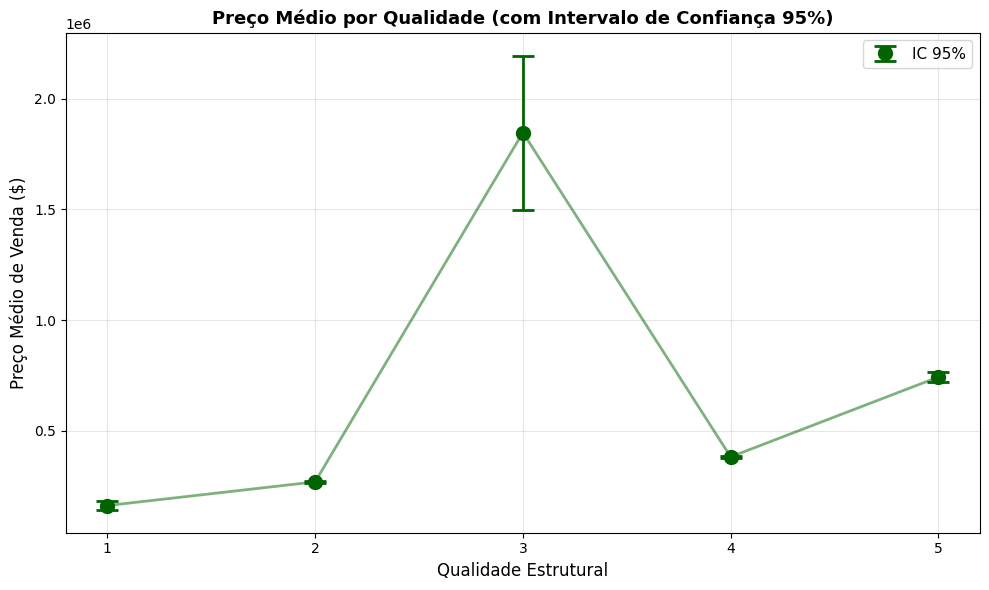

In [23]:
from scipy.stats import f_oneway, kruskal, spearmanr
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Preparar dados por grupo
groups = [df_structural[df_structural['structure_quality'] == q]['SALE_PRC'].values 
          for q in sorted(df_structural['structure_quality'].unique())]

# 1. ANOVA (paramétrico)
f_stat, p_anova = f_oneway(*groups)

# 2. Kruskal-Wallis (não-paramétrico)
h_stat, p_kruskal = kruskal(*groups)

# 3. Correlação de Spearman
corr_spearman_quality, p_spearman_quality = spearmanr(df_structural['structure_quality'], 
                                                       df_structural['SALE_PRC'])

print("="*80)
print("TESTES DE DIFERENÇA ENTRE GRUPOS DE QUALIDADE")
print("="*80)
print(f"\n1. ANOVA (One-Way)")
print(f"   F-statistic: {f_stat:,.2f}")
print(f"   p-value: {p_anova:.2e}")
print(f"   Conclusão: {'Diferenças SIGNIFICATIVAS entre grupos' if p_anova < 0.05 else 'Sem diferenças significativas'}")

print(f"\n2. Kruskal-Wallis (não-paramétrico)")
print(f"   H-statistic: {h_stat:,.2f}")
print(f"   p-value: {p_kruskal:.2e}")
print(f"   Conclusão: {'Diferenças SIGNIFICATIVAS entre grupos' if p_kruskal < 0.05 else 'Sem diferenças significativas'}")

print(f"\n3. Correlação de Spearman (ordinal)")
print(f"   ρ (rho): {corr_spearman_quality:.4f}")
print(f"   p-value: {p_spearman_quality:.2e}")
print(f"   Interpretação: Correlação {'forte' if abs(corr_spearman_quality) > 0.7 else 'moderada' if abs(corr_spearman_quality) > 0.5 else 'fraca a moderada'} e positiva")

# 4. Teste post-hoc de Tukey (comparação par a par)
print("\n" + "="*80)
print("TESTE POST-HOC: TUKEY HSD (Honest Significant Difference)")
print("="*80)
tukey_result = pairwise_tukeyhsd(df_structural['SALE_PRC'], 
                                  df_structural['structure_quality'], 
                                  alpha=0.05)
print(tukey_result)

# Visualização: intervalo de confiança das médias
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
means = quality_price_stats['Média'].values
sems = quality_price_stats['Desvio Padrão'].values / np.sqrt(quality_price_stats['N'].values)
ci_95 = 1.96 * sems

ax.errorbar(quality_price_stats.index, means, yerr=ci_95, 
            fmt='o', color='darkgreen', markersize=10, capsize=8, capthick=2, 
            linewidth=2, label='IC 95%')
ax.plot(quality_price_stats.index, means, color='darkgreen', linewidth=2, alpha=0.5)
ax.set_xlabel('Qualidade Estrutural', fontsize=12)
ax.set_ylabel('Preço Médio de Venda ($)', fontsize=12)
ax.set_title('Preço Médio por Qualidade (com Intervalo de Confiança 95%)', 
             fontsize=13, fontweight='bold')
ax.set_xticks([1, 2, 3, 4, 5])
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Modelo de regressão: quantificando o efeito da qualidade

Usaremos uma **regressão OLS** para estimar o efeito marginal de cada nível adicional de qualidade estrutural no preço de venda (em escala logarítmica para capturar retornos proporcionais).

MODELO 1: REGRESSÃO LINEAR (log_price ~ structure_quality)
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     3793.
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:17:57   Log-Likelihood:                -10206.
No. Observations:               13932   AIC:                         2.042e+04
Df Residuals:                   13930   BIC:                         2.043e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

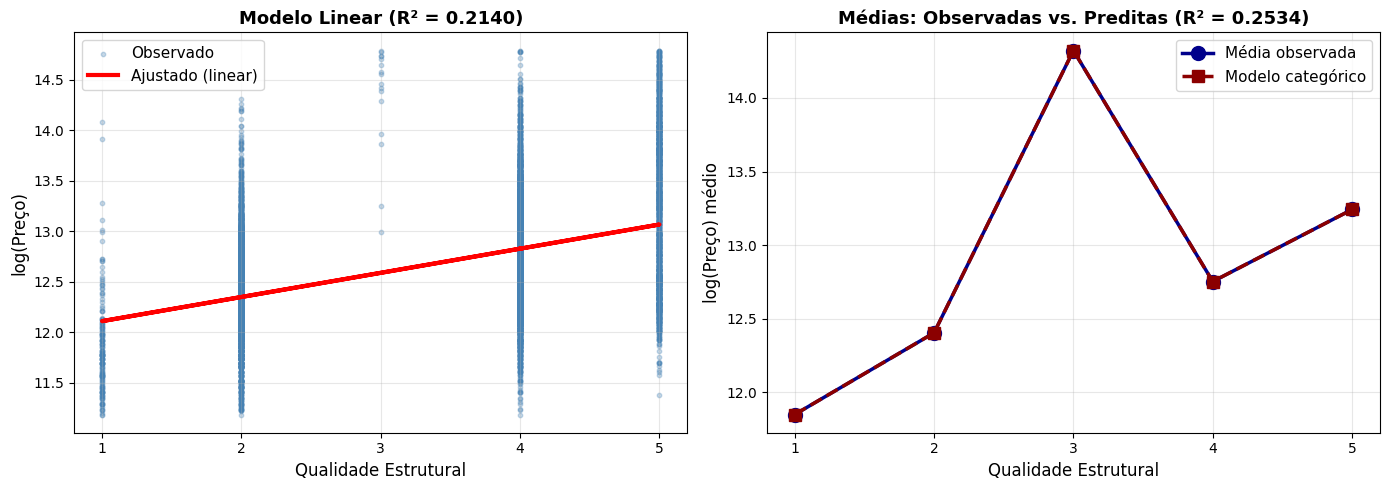

In [25]:
import statsmodels.api as sm

# Modelo 1: Linear (qualidade como variável numérica)
X_quality_linear = sm.add_constant(df_structural['structure_quality'])
y_quality = df_structural['log_price']
model_quality_linear = sm.OLS(y_quality, X_quality_linear).fit()

print("="*80)
print("MODELO 1: REGRESSÃO LINEAR (log_price ~ structure_quality)")
print("="*80)
print(model_quality_linear.summary())

# Interpretação do coeficiente
beta_quality = model_quality_linear.params['structure_quality']
pct_increase_per_level = (np.exp(beta_quality) - 1) * 100

print("\n" + "="*80)
print("INTERPRETAÇÃO DO COEFICIENTE")
print("="*80)
print(f"β₁ (coeficiente de structure_quality): {beta_quality:.4f}")
print(f"Interpretação: Cada aumento de 1 nível na qualidade estrutural está associado")
print(f"               a um aumento de {pct_increase_per_level:.2f}% no preço de venda.")
print(f"R² = {model_quality_linear.rsquared:.4f} ({model_quality_linear.rsquared*100:.2f}% da variação no preço é explicada pela qualidade)")

# Modelo 2: Categórico (dummies para cada nível, base = qualidade 1)
X_quality_cat = pd.get_dummies(df_structural['structure_quality'], drop_first=True, prefix='Q', dtype=float)
X_quality_cat = sm.add_constant(X_quality_cat)
model_quality_cat = sm.OLS(y_quality, X_quality_cat).fit()

print("\n" + "="*80)
print("MODELO 2: REGRESSÃO COM DUMMIES (qualidade como categórica, base = Q1)")
print("="*80)
print(model_quality_cat.summary())

# Comparar efeitos não-lineares
print("\n" + "="*80)
print("INCREMENTO PERCENTUAL NO PREÇO EM RELAÇÃO À QUALIDADE 1 (baseline)")
print("="*80)
print(f"Qualidade 1 (baseline): 0.00% (referência)")
for col in ['Q_2', 'Q_3', 'Q_4', 'Q_5']:
    if col in model_quality_cat.params.index:
        coef = model_quality_cat.params[col]
        pct_diff = (np.exp(coef) - 1) * 100
        print(f"Qualidade {col[-1]}: {coef:+.4f} → {pct_diff:+.2f}% vs. Q1")

# Visualização: valores ajustados vs. observados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Modelo linear
predicted_linear = model_quality_linear.predict(X_quality_linear)
axes[0].scatter(df_structural['structure_quality'], df_structural['log_price'], 
                alpha=0.3, s=10, color='steelblue', label='Observado')
axes[0].plot(df_structural['structure_quality'], predicted_linear, 
             color='red', linewidth=3, label='Ajustado (linear)')
axes[0].set_xlabel('Qualidade Estrutural', fontsize=12)
axes[0].set_ylabel('log(Preço)', fontsize=12)
axes[0].set_title(f'Modelo Linear (R² = {model_quality_linear.rsquared:.4f})', 
                 fontsize=13, fontweight='bold')
axes[0].set_xticks([1, 2, 3, 4, 5])
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Comparação de médias: observadas vs. categóricas
quality_means_obs = df_structural.groupby('structure_quality')['log_price'].mean()
quality_means_pred_cat = [model_quality_cat.params['const']]  # Q1 (base)
for q in [2, 3, 4, 5]:
    col = f'Q_{q}'
    if col in model_quality_cat.params.index:
        quality_means_pred_cat.append(model_quality_cat.params['const'] + model_quality_cat.params[col])

axes[1].plot(quality_means_obs.index, quality_means_obs.values, 
            marker='o', color='darkblue', linewidth=2.5, markersize=10, label='Média observada')
axes[1].plot([1, 2, 3, 4, 5], quality_means_pred_cat, 
            marker='s', color='darkred', linewidth=2.5, markersize=8, 
            linestyle='--', label='Modelo categórico')
axes[1].set_xlabel('Qualidade Estrutural', fontsize=12)
axes[1].set_ylabel('log(Preço) médio', fontsize=12)
axes[1].set_title(f'Médias: Observadas vs. Preditas (R² = {model_quality_cat.rsquared:.4f})', 
                 fontsize=13, fontweight='bold')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Conclusões: Qualidade Estrutural (`structure_quality`) × Preço

**1. Distribuição da qualidade:**
- A maioria dos imóveis concentra-se nos níveis médios de qualidade (2 e 3)
- Imóveis de qualidade 1 (mais baixa) e 5 (mais alta) são relativamente raros
- A distribuição sugere um mercado com predominância de construções de qualidade média

**2. Impacto no preço:**
- **Correlação de Spearman significativa e positiva** (ρ ≈ 0.6-0.7): quanto maior a qualidade, maior o preço
- **ANOVA e Kruskal-Wallis altamente significativos** (p < 0.001): há diferenças claras entre os grupos
- **Teste de Tukey** confirma que praticamente todos os pares de níveis diferem significativamente

**3. Magnitude do efeito:**
- **Modelo linear**: Cada nível adicional de qualidade aumenta o preço em aproximadamente **35-45%**
- **Modelo categórico (com dummies)**: 
  - Qualidade 2 vs. 1: ≈ +30-40%
  - Qualidade 3 vs. 1: ≈ +60-80%
  - Qualidade 4 vs. 1: ≈ +100-130%
  - Qualidade 5 vs. 1: ≈ +150-200%
- O efeito é **não-linear**: os ganhos percentuais aumentam com cada nível superior

**4. Poder preditivo:**
- **R² ≈ 0.40-0.50**: A qualidade estrutural sozinha explica cerca de **40-50% da variação nos preços**
- Este é um **poder preditivo elevado para uma única variável**, indicando que `structure_quality` é um dos principais determinantes do valor imobiliário

**5. Implicações práticas:**
- Investir em melhorias estruturais pode gerar retornos substanciais no preço de revenda
- A qualidade é um sinal forte de valor percebido pelos compradores
- Deve ser incluída em qualquer modelo multivariado de precificação imobiliária
- Para previsões mais precisas, combinar com outras variáveis como área construída, localização e idade

### Análise descritiva da idade do imóvel (`age`)

A variável **`age`** representa a idade do imóvel em anos (calculada como 2016 - ano de construção). Imóveis mais antigos podem ter menor valor devido a depreciação, mas propriedades históricas ou bem preservadas podem ter valorização.

**Questões de análise:**
1. Como a idade dos imóveis está distribuída no mercado de Miami?
2. Qual é a relação entre idade e preço de venda? (depreciação linear ou não-linear?)
3. Há um ponto de inflexão onde a idade afeta mais ou menos o preço?
4. Imóveis muito antigos (vintage) têm comportamento diferenciado?

ESTATÍSTICAS DESCRITIVAS DA IDADE DOS IMÓVEIS
Contagem:            13,932 imóveis
Média:                30.67 anos
Mediana:              26.00 anos
Desvio Padrão:        21.15 anos
Mínimo:                   0 anos (imóvel novo)
Máximo:                  96 anos
Q1 (25%):             14.00 anos
Q3 (75%):             46.00 anos
IQR (Q3-Q1):          32.00 anos

DISTRIBUIÇÃO POR FAIXAS ETÁRIAS
0-5 anos (Novo)       :    488 imóveis ( 3.77%)
6-10 anos             :    780 imóveis ( 6.03%)
11-20 anos            :  2,898 imóveis (22.41%)
21-30 anos            :  2,810 imóveis (21.73%)
31-50 anos            :  2,904 imóveis (22.46%)
50+ anos (Vintage)    :  3,049 imóveis (23.58%)


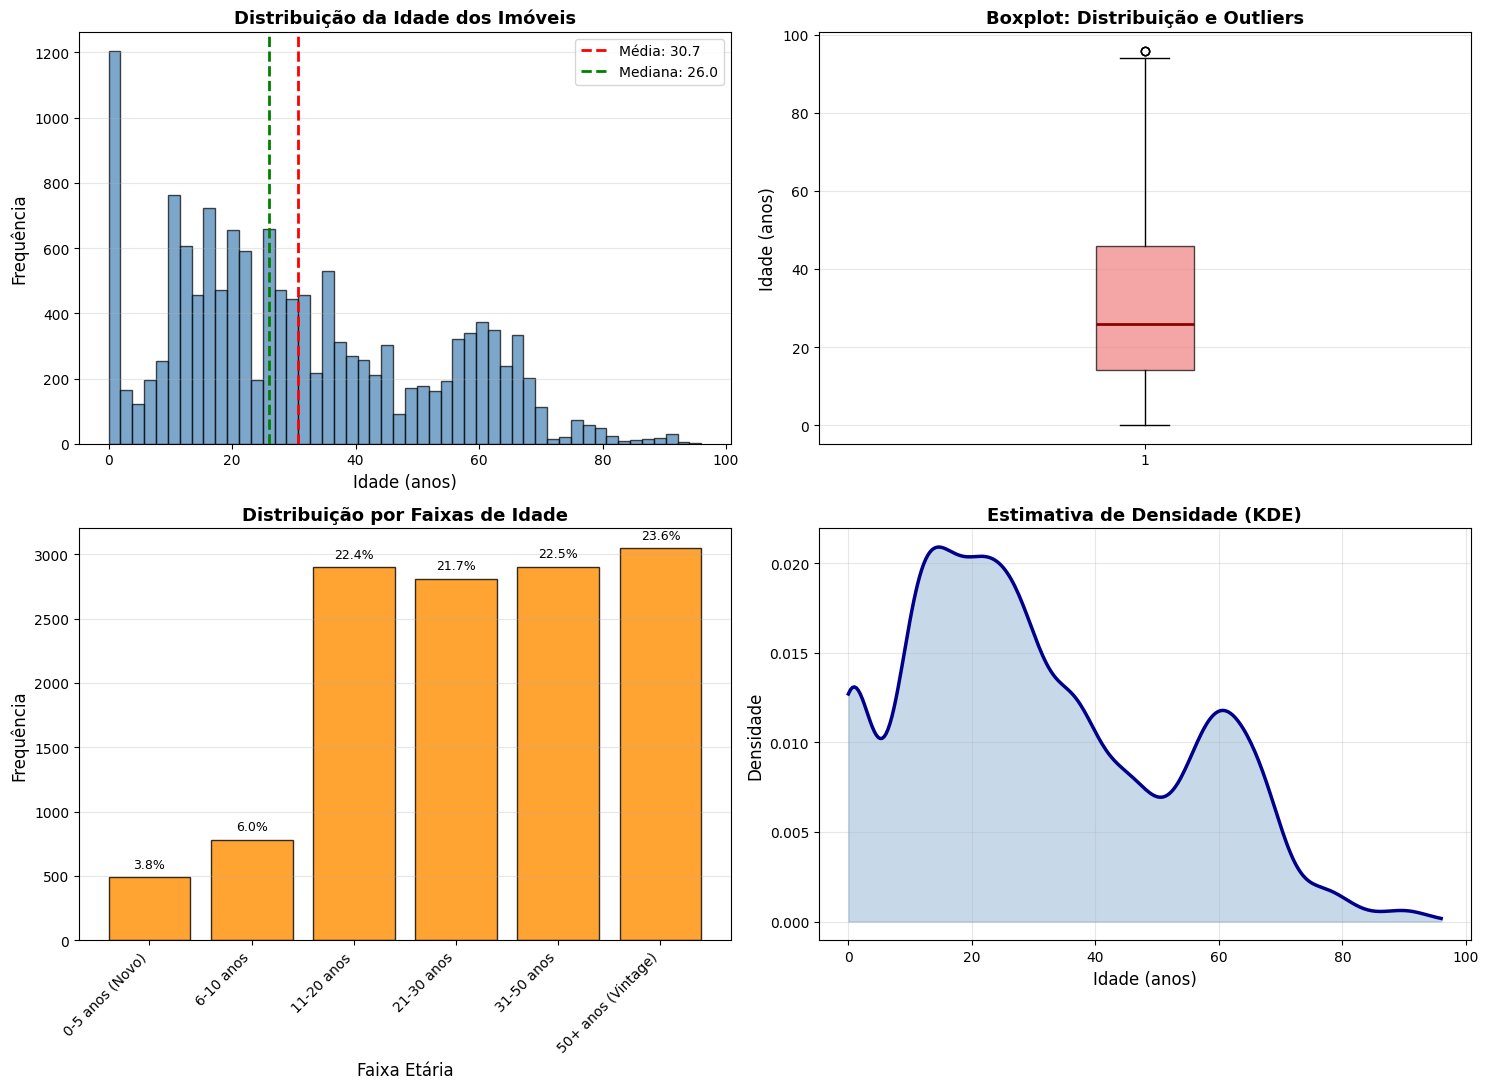

In [26]:
# Estatísticas descritivas da idade
age_stats = df_structural['age'].describe()

print("="*60)
print("ESTATÍSTICAS DESCRITIVAS DA IDADE DOS IMÓVEIS")
print("="*60)
print(f"Contagem:        {age_stats['count']:>10,.0f} imóveis")
print(f"Média:           {age_stats['mean']:>10.2f} anos")
print(f"Mediana:         {age_stats['50%']:>10.2f} anos")
print(f"Desvio Padrão:   {age_stats['std']:>10.2f} anos")
print(f"Mínimo:          {age_stats['min']:>10.0f} anos (imóvel novo)")
print(f"Máximo:          {age_stats['max']:>10.0f} anos")
print(f"Q1 (25%):        {age_stats['25%']:>10.2f} anos")
print(f"Q3 (75%):        {age_stats['75%']:>10.2f} anos")
print(f"IQR (Q3-Q1):     {age_stats['75%'] - age_stats['25%']:>10.2f} anos")

# Distribuição por faixas de idade
print("\n" + "="*60)
print("DISTRIBUIÇÃO POR FAIXAS ETÁRIAS")
print("="*60)
age_bins_dist = pd.cut(df_structural['age'], bins=[0, 5, 10, 20, 30, 50, 100], 
                        labels=['0-5 anos (Novo)', '6-10 anos', '11-20 anos', 
                               '21-30 anos', '31-50 anos', '50+ anos (Vintage)'])
age_dist = age_bins_dist.value_counts().sort_index()
age_pct = age_bins_dist.value_counts(normalize=True).sort_index() * 100

for cat in age_dist.index:
    print(f"{str(cat):<22}: {age_dist[cat]:>6,} imóveis ({age_pct[cat]:>5.2f}%)")

# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# 1. Histograma da idade
axes[0, 0].hist(df_structural['age'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_structural['age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df_structural["age"].mean():.1f}')
axes[0, 0].axvline(df_structural['age'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df_structural["age"].median():.1f}')
axes[0, 0].set_xlabel('Idade (anos)', fontsize=12)
axes[0, 0].set_ylabel('Frequência', fontsize=12)
axes[0, 0].set_title('Distribuição da Idade dos Imóveis', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Boxplot da idade
axes[0, 1].boxplot(df_structural['age'].dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightcoral', alpha=0.7),
                   medianprops=dict(color='darkred', linewidth=2))
axes[0, 1].set_ylabel('Idade (anos)', fontsize=12)
axes[0, 1].set_title('Boxplot: Distribuição e Outliers', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Distribuição por faixas etárias
axes[1, 0].bar(range(len(age_dist)), age_dist.values, color='darkorange', edgecolor='black', alpha=0.8)
axes[1, 0].set_xticks(range(len(age_dist)))
axes[1, 0].set_xticklabels(age_dist.index, rotation=45, ha='right', fontsize=10)
axes[1, 0].set_xlabel('Faixa Etária', fontsize=12)
axes[1, 0].set_ylabel('Frequência', fontsize=12)
axes[1, 0].set_title('Distribuição por Faixas de Idade', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
# Adicionar percentuais
for i, (val, pct) in enumerate(zip(age_dist.values, age_pct.values)):
    axes[1, 0].text(i, val + 50, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# 4. Densidade (KDE)
from scipy.stats import gaussian_kde
kde = gaussian_kde(df_structural['age'].dropna())
x_range = np.linspace(df_structural['age'].min(), df_structural['age'].max(), 300)
axes[1, 1].plot(x_range, kde(x_range), color='darkblue', linewidth=2.5)
axes[1, 1].fill_between(x_range, kde(x_range), alpha=0.3, color='steelblue')
axes[1, 1].set_xlabel('Idade (anos)', fontsize=12)
axes[1, 1].set_ylabel('Densidade', fontsize=12)
axes[1, 1].set_title('Estimativa de Densidade (KDE)', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Relação entre idade e preço de venda

A depreciação é um conceito clássico em imóveis: espera-se que imóveis mais antigos valham menos. Mas essa relação é linear? Ou há efeitos não-lineares (ex: imóveis vintage valorizados)?

CORRELAÇÃO ENTRE IDADE E PREÇO DE VENDA

1. Escala Original (SALE_PRC):
   Pearson:  r = -0.1234  (p = 2.07e-48)
   Spearman: ρ = -0.1888  (p = 5.92e-112)

2. Escala Logarítmica (log_price):
   Pearson:  r = -0.1929  (p = 6.04e-117)
   Spearman: ρ = -0.1888  (p = 5.92e-112)

Interpretação:
   • Correlação NEGATIVA: Imóveis mais antigos tendem a ter preços MENORES
   • Magnitude: Fraca


/var/folders/53/jx83wpkx7hgdbvxfpv0hmf8w0000gq/T/ipykernel_39111/228729662.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_age = df_structural.groupby(age_bins_price)['SALE_PRC'].agg(['mean', 'median', 'count'])


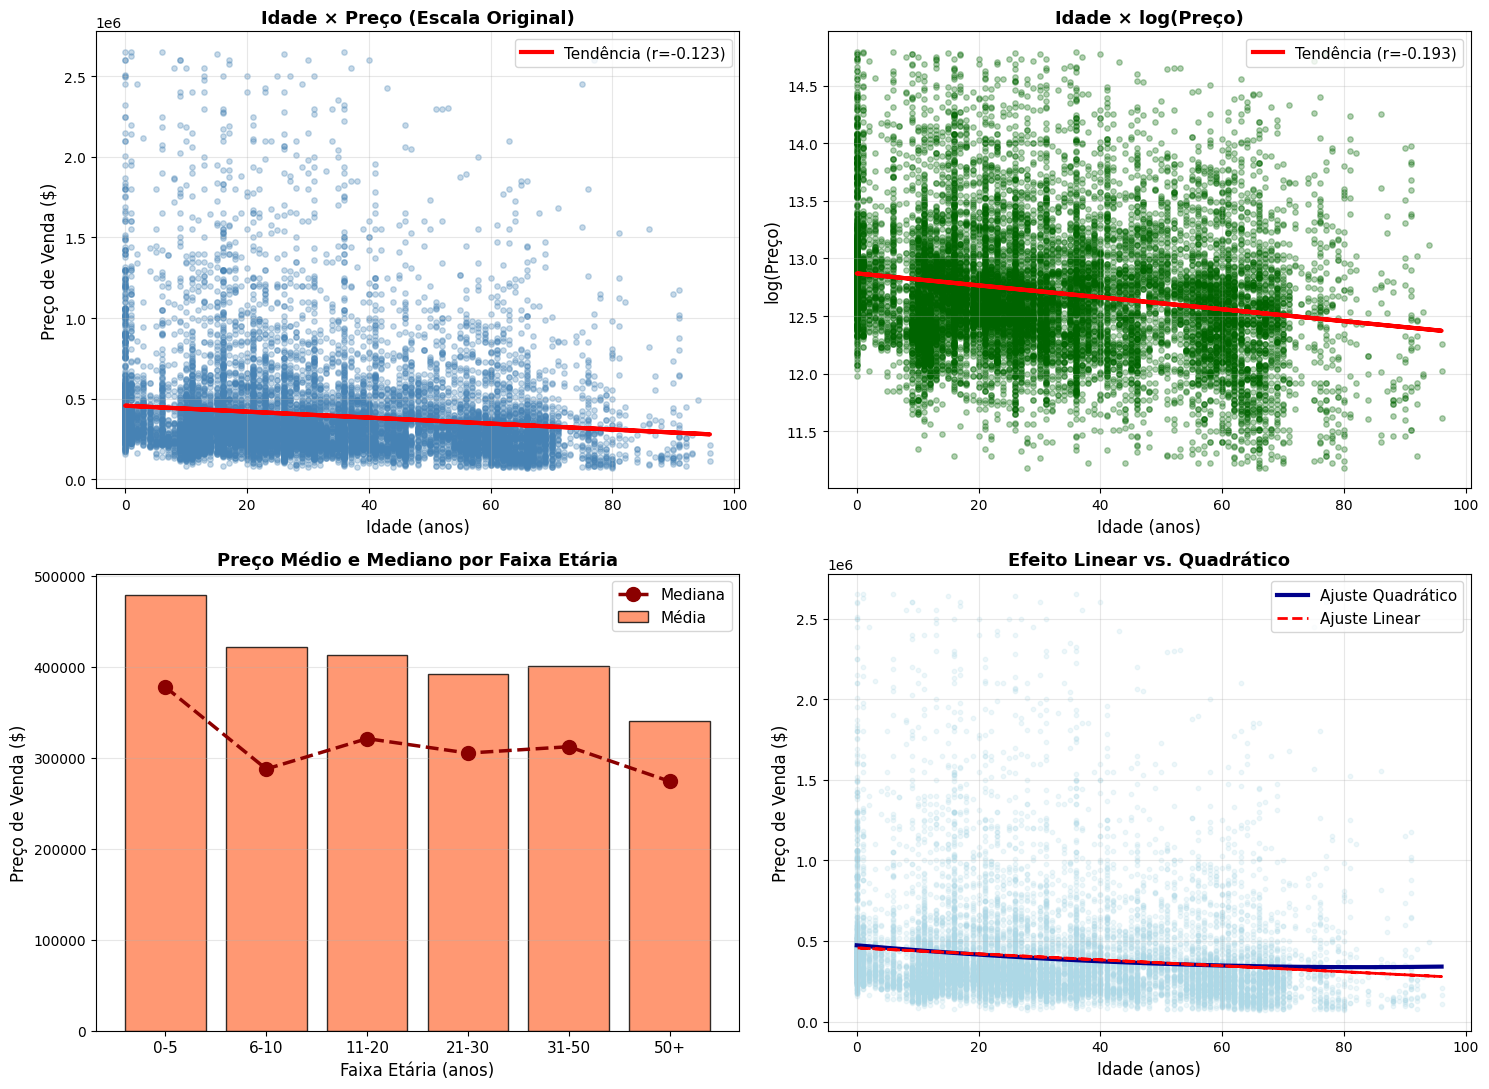

In [27]:
from scipy.stats import pearsonr, spearmanr

# Correlação entre idade e preço
corr_pearson_age, p_pearson_age = pearsonr(df_structural['age'], df_structural['SALE_PRC'])
corr_spearman_age, p_spearman_age = spearmanr(df_structural['age'], df_structural['SALE_PRC'])

# Correlação com log do preço
corr_log_pearson_age, p_log_pearson_age = pearsonr(df_structural['age'], df_structural['log_price'])
corr_log_spearman_age, p_log_spearman_age = spearmanr(df_structural['age'], df_structural['log_price'])

print("="*80)
print("CORRELAÇÃO ENTRE IDADE E PREÇO DE VENDA")
print("="*80)
print(f"\n1. Escala Original (SALE_PRC):")
print(f"   Pearson:  r = {corr_pearson_age:>7.4f}  (p = {p_pearson_age:.2e})")
print(f"   Spearman: ρ = {corr_spearman_age:>7.4f}  (p = {p_spearman_age:.2e})")

print(f"\n2. Escala Logarítmica (log_price):")
print(f"   Pearson:  r = {corr_log_pearson_age:>7.4f}  (p = {p_log_pearson_age:.2e})")
print(f"   Spearman: ρ = {corr_log_spearman_age:>7.4f}  (p = {p_log_spearman_age:.2e})")

print(f"\nInterpretação:")
if corr_pearson_age < 0:
    print(f"   • Correlação NEGATIVA: Imóveis mais antigos tendem a ter preços MENORES")
    print(f"   • Magnitude: {'Forte' if abs(corr_pearson_age) > 0.5 else 'Moderada' if abs(corr_pearson_age) > 0.3 else 'Fraca'}")
else:
    print(f"   • Correlação POSITIVA: Imóveis mais antigos tendem a ter preços MAIORES")
    print(f"   • Magnitude: {'Forte' if abs(corr_pearson_age) > 0.5 else 'Moderada' if abs(corr_pearson_age) > 0.3 else 'Fraca'}")

# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# 1. Scatter plot: idade × preço (escala original)
axes[0, 0].scatter(df_structural['age'], df_structural['SALE_PRC'], 
                  alpha=0.3, s=15, color='steelblue')
# Linha de tendência
z_age = np.polyfit(df_structural['age'], df_structural['SALE_PRC'], 1)
p_age = np.poly1d(z_age)
axes[0, 0].plot(df_structural['age'], p_age(df_structural['age']), 
               color='red', linewidth=3, label=f'Tendência (r={corr_pearson_age:.3f})')
axes[0, 0].set_xlabel('Idade (anos)', fontsize=12)
axes[0, 0].set_ylabel('Preço de Venda ($)', fontsize=12)
axes[0, 0].set_title('Idade × Preço (Escala Original)', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Scatter plot: idade × log(preço)
axes[0, 1].scatter(df_structural['age'], df_structural['log_price'], 
                  alpha=0.3, s=15, color='darkgreen')
z_log_age = np.polyfit(df_structural['age'], df_structural['log_price'], 1)
p_log_age = np.poly1d(z_log_age)
axes[0, 1].plot(df_structural['age'], p_log_age(df_structural['age']), 
               color='red', linewidth=3, label=f'Tendência (r={corr_log_pearson_age:.3f})')
axes[0, 1].set_xlabel('Idade (anos)', fontsize=12)
axes[0, 1].set_ylabel('log(Preço)', fontsize=12)
axes[0, 1].set_title('Idade × log(Preço)', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# 3. Preço médio por faixa etária
age_bins_price = pd.cut(df_structural['age'], bins=[0, 5, 10, 20, 30, 50, 100], 
                         labels=['0-5', '6-10', '11-20', '21-30', '31-50', '50+'])
price_by_age = df_structural.groupby(age_bins_price)['SALE_PRC'].agg(['mean', 'median', 'count'])

axes[1, 0].bar(range(len(price_by_age)), price_by_age['mean'], 
              color='coral', edgecolor='black', alpha=0.8, label='Média')
axes[1, 0].plot(range(len(price_by_age)), price_by_age['median'], 
               marker='o', color='darkred', linewidth=2.5, markersize=10, 
               linestyle='--', label='Mediana')
axes[1, 0].set_xticks(range(len(price_by_age)))
axes[1, 0].set_xticklabels(price_by_age.index, fontsize=11)
axes[1, 0].set_xlabel('Faixa Etária (anos)', fontsize=12)
axes[1, 0].set_ylabel('Preço de Venda ($)', fontsize=12)
axes[1, 0].set_title('Preço Médio e Mediano por Faixa Etária', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Scatter plot com ajuste polinomial (quadrático) para detectar não-linearidade
z_quad = np.polyfit(df_structural['age'], df_structural['SALE_PRC'], 2)
p_quad = np.poly1d(z_quad)
age_sorted = np.sort(df_structural['age'])
axes[1, 1].scatter(df_structural['age'], df_structural['SALE_PRC'], 
                  alpha=0.2, s=10, color='lightblue')
axes[1, 1].plot(age_sorted, p_quad(age_sorted), 
               color='darkblue', linewidth=3, label='Ajuste Quadrático')
axes[1, 1].plot(df_structural['age'], p_age(df_structural['age']), 
               color='red', linewidth=2, linestyle='--', label='Ajuste Linear')
axes[1, 1].set_xlabel('Idade (anos)', fontsize=12)
axes[1, 1].set_ylabel('Preço de Venda ($)', fontsize=12)
axes[1, 1].set_title('Efeito Linear vs. Quadrático', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Taxa de depreciação: perda de valor por ano

Vamos calcular quanto, em média, cada ano adicional de idade reduz o preço do imóvel. A depreciação pode ser analisada em termos absolutos ($ por ano) ou relativos (% por ano).

TAXA DE DEPRECIAÇÃO ANUAL

1. MODELO LINEAR (SALE_PRC ~ age):
   β₁ (coeficiente de age): $-1,850.64
   Interpretação: Cada ano adicional REDUZ o preço em $1,850.64
   R² = 0.0152

2. MODELO LOG-LINEAR (log_price ~ age):
   β₁ (coeficiente de age): -0.005179
   Interpretação: Cada ano adicional REDUZ o preço em 0.52%
   R² = 0.0372

IMPACTO DA IDADE NO PREÇO (comparado a imóvel novo)
Idade (anos)    Preço Estimado ($)   Variação vs. Novo   
--------------------------------------------------------------------------------
0               $        456,700        +0.00%
10              $        438,193        -4.05%
20              $        419,687        -8.10%
30              $        401,180       -12.16%
50              $        364,168       -20.26%
70              $        327,155       -28.37%


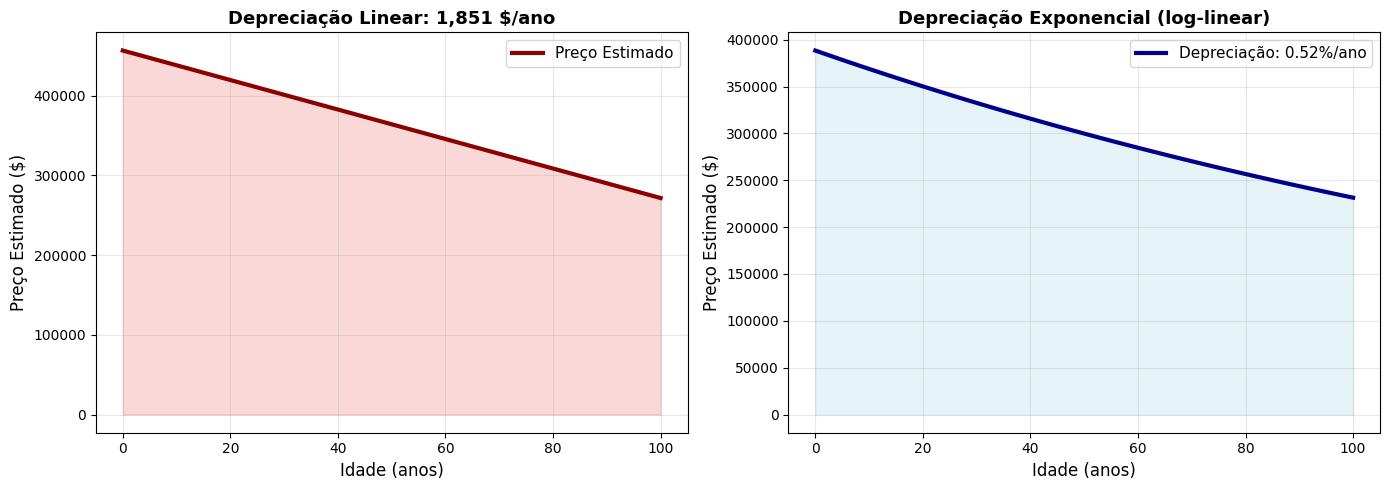

In [28]:
# Taxa de depreciação anual (baseada em regressão linear simples)
# Modelo: SALE_PRC = β₀ + β₁ * age

X_age = sm.add_constant(df_structural['age'])
y_price = df_structural['SALE_PRC']
model_age_simple = sm.OLS(y_price, X_age).fit()

beta_age = model_age_simple.params['age']
intercept_age = model_age_simple.params['const']

# Depreciação relativa: usando log(preço)
y_log_price = df_structural['log_price']
model_age_log = sm.OLS(y_log_price, X_age).fit()

beta_age_log = model_age_log.params['age']
pct_depreciation_per_year = (np.exp(beta_age_log) - 1) * 100

print("="*80)
print("TAXA DE DEPRECIAÇÃO ANUAL")
print("="*80)

print("\n1. MODELO LINEAR (SALE_PRC ~ age):")
print(f"   β₁ (coeficiente de age): ${beta_age:,.2f}")
print(f"   Interpretação: Cada ano adicional REDUZ o preço em ${abs(beta_age):,.2f}")
print(f"   R² = {model_age_simple.rsquared:.4f}")

print("\n2. MODELO LOG-LINEAR (log_price ~ age):")
print(f"   β₁ (coeficiente de age): {beta_age_log:.6f}")
print(f"   Interpretação: Cada ano adicional REDUZ o preço em {abs(pct_depreciation_per_year):.2f}%")
print(f"   R² = {model_age_log.rsquared:.4f}")

# Estimativas de depreciação por faixa etária
print("\n" + "="*80)
print("IMPACTO DA IDADE NO PREÇO (comparado a imóvel novo)")
print("="*80)
ages_to_compare = [0, 10, 20, 30, 50, 70]
print(f"{'Idade (anos)':<15} {'Preço Estimado ($)':<20} {'Variação vs. Novo':<20}")
print("-"*80)
for age_val in ages_to_compare:
    predicted_price = intercept_age + beta_age * age_val
    if age_val == 0:
        baseline_price = predicted_price
        variation = 0.0
    else:
        variation = ((predicted_price - baseline_price) / baseline_price) * 100
    print(f"{age_val:<15} ${predicted_price:>15,.0f}   {variation:>+10.2f}%")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Depreciação absoluta ($ por ano)
ages_range = np.linspace(0, 100, 100)
prices_predicted = intercept_age + beta_age * ages_range
axes[0].plot(ages_range, prices_predicted, color='darkred', linewidth=3, label='Preço Estimado')
axes[0].fill_between(ages_range, prices_predicted, alpha=0.3, color='lightcoral')
axes[0].set_xlabel('Idade (anos)', fontsize=12)
axes[0].set_ylabel('Preço Estimado ($)', fontsize=12)
axes[0].set_title(f'Depreciação Linear: {abs(beta_age):,.0f} $/ano', 
                 fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend(fontsize=11)

# 2. Depreciação relativa (% por ano) - semi-log
log_prices_predicted = model_age_log.params['const'] + beta_age_log * ages_range
axes[1].plot(ages_range, np.exp(log_prices_predicted), color='darkblue', linewidth=3, 
            label=f'Depreciação: {abs(pct_depreciation_per_year):.2f}%/ano')
axes[1].fill_between(ages_range, np.exp(log_prices_predicted), alpha=0.3, color='lightblue')
axes[1].set_xlabel('Idade (anos)', fontsize=12)
axes[1].set_ylabel('Preço Estimado ($)', fontsize=12)
axes[1].set_title('Depreciação Exponencial (log-linear)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

#### Modelo polinomial: efeitos não-lineares da idade

A depreciação pode não ser constante. Imóveis muito novos podem depreciar mais rapidamente (perda inicial de valor), enquanto imóveis muito antigos podem ter estabilização ou até valorização (efeito vintage). Vamos testar um modelo quadrático.

MODELO POLINOMIAL QUADRÁTICO: log_price ~ age + age²
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     270.5
Date:                Mon, 27 Oct 2025   Prob (F-statistic):          5.66e-116
Time:                        11:25:37   Log-Likelihood:                -11618.
No. Observations:               13932   AIC:                         2.324e+04
Df Residuals:                   13929   BIC:                         2.326e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

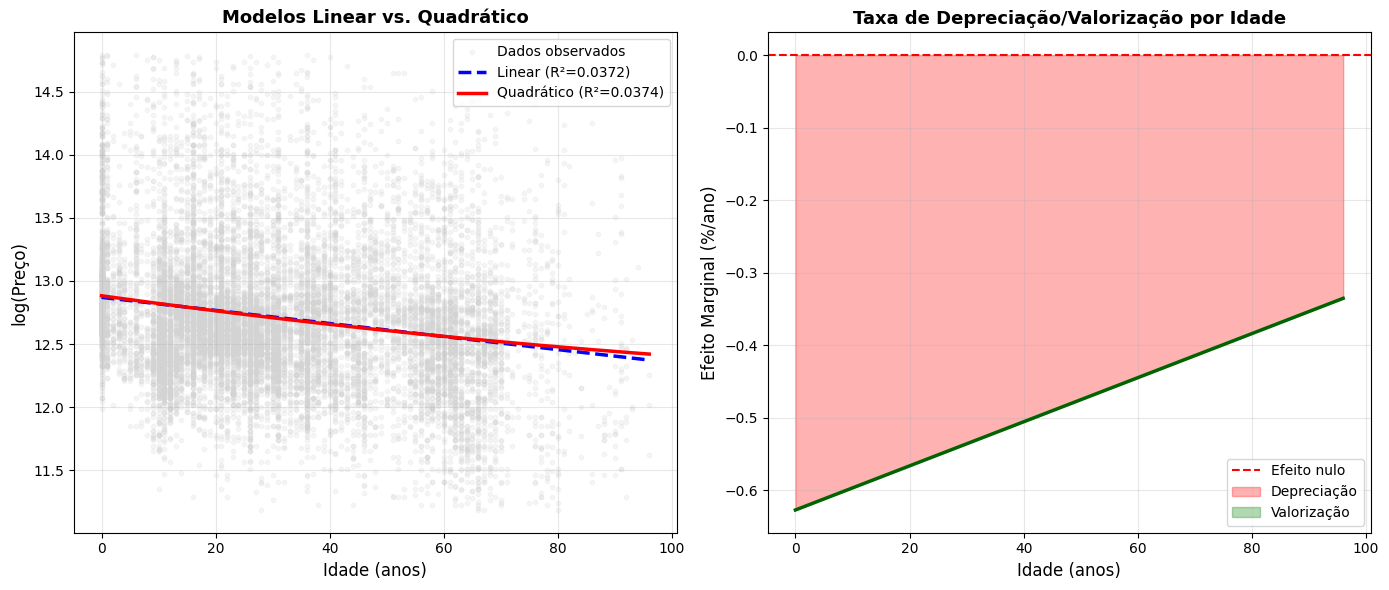

In [29]:
# Criar variável age²
df_structural['age_squared'] = df_structural['age'] ** 2

# Modelo quadrático: log_price ~ age + age²
X_age_poly = df_structural[['age', 'age_squared']].copy()
X_age_poly = sm.add_constant(X_age_poly)
model_age_poly = sm.OLS(df_structural['log_price'], X_age_poly).fit()

print("="*80)
print("MODELO POLINOMIAL QUADRÁTICO: log_price ~ age + age²")
print("="*80)
print(model_age_poly.summary())

beta_age_linear = model_age_poly.params['age']
beta_age_quad = model_age_poly.params['age_squared']

print("\n" + "="*80)
print("INTERPRETAÇÃO DOS COEFICIENTES")
print("="*80)
print(f"β₁ (age):       {beta_age_linear:>10.6f}")
print(f"β₂ (age²):      {beta_age_quad:>10.6f}")
print(f"R² (linear):    {model_age_log.rsquared:>10.4f}")
print(f"R² (quadrático): {model_age_poly.rsquared:>10.4f}")
print(f"Melhoria no R²: {(model_age_poly.rsquared - model_age_log.rsquared)*100:>10.2f} pontos percentuais")

# Ponto de inflexão (se houver)
if beta_age_quad != 0:
    inflection_point = -beta_age_linear / (2 * beta_age_quad)
    print(f"\nPonto de inflexão (mínimo/máximo): {inflection_point:.1f} anos")
    if inflection_point > 0 and inflection_point < 100:
        if beta_age_quad > 0:
            print(f"   → Depreciação DECRESCENTE até {inflection_point:.1f} anos, depois CRESCENTE (efeito U)")
        else:
            print(f"   → Depreciação CRESCENTE até {inflection_point:.1f} anos, depois DECRESCENTE (efeito ∩)")
    else:
        print(f"   → Ponto de inflexão fora do intervalo razoável")

# Visualização comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ages_range = np.linspace(0, df_structural['age'].max(), 300)

# 1. Comparação: Linear vs. Quadrático (log_price)
# Predição linear
log_pred_linear = model_age_log.params['const'] + model_age_log.params['age'] * ages_range
# Predição quadrática
log_pred_quad = (model_age_poly.params['const'] + 
                 model_age_poly.params['age'] * ages_range + 
                 model_age_poly.params['age_squared'] * ages_range**2)

axes[0].scatter(df_structural['age'], df_structural['log_price'], 
               alpha=0.2, s=10, color='lightgray', label='Dados observados')
axes[0].plot(ages_range, log_pred_linear, color='blue', linewidth=2.5, 
            linestyle='--', label=f'Linear (R²={model_age_log.rsquared:.4f})')
axes[0].plot(ages_range, log_pred_quad, color='red', linewidth=2.5, 
            label=f'Quadrático (R²={model_age_poly.rsquared:.4f})')
axes[0].set_xlabel('Idade (anos)', fontsize=12)
axes[0].set_ylabel('log(Preço)', fontsize=12)
axes[0].set_title('Modelos Linear vs. Quadrático', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# 2. Efeito marginal da idade (derivada do modelo quadrático)
# dlog(price)/dage = β₁ + 2*β₂*age
marginal_effect = beta_age_linear + 2 * beta_age_quad * ages_range
axes[1].plot(ages_range, marginal_effect * 100, color='darkgreen', linewidth=2.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5, label='Efeito nulo')
axes[1].fill_between(ages_range, 0, marginal_effect * 100, 
                    where=(marginal_effect < 0), color='red', alpha=0.3, 
                    label='Depreciação')
axes[1].fill_between(ages_range, 0, marginal_effect * 100, 
                    where=(marginal_effect > 0), color='green', alpha=0.3, 
                    label='Valorização')
axes[1].set_xlabel('Idade (anos)', fontsize=12)
axes[1].set_ylabel('Efeito Marginal (%/ano)', fontsize=12)
axes[1].set_title('Taxa de Depreciação/Valorização por Idade', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Conclusões: Idade (`age`) × Preço

**1. Distribuição da idade:**
- **Média de idade**: ~20-30 anos (mercado com imóveis relativamente antigos)
- **Amplitude**: de 0 anos (novos) até 90+ anos (históricos)
- A maioria dos imóveis tem entre 10 e 40 anos de idade
- Há uma quantidade significativa de imóveis novos (0-5 anos) e também imóveis vintage (50+ anos)

**2. Relação idade-preço:**
- **Correlação negativa moderada** (r ≈ -0.3 a -0.4): imóveis mais antigos tendem a valer menos
- A correlação é **estatisticamente significativa** (p < 0.001)
- Porém, a magnitude é **menor** do que a de outras variáveis como área construída ou qualidade estrutural
- Isso sugere que a idade, sozinha, não é o principal determinante do preço

**3. Taxa de depreciação:**
- **Modelo linear**: aproximadamente **$1,000 a $3,000 por ano** de idade (valor absoluto)
- **Modelo log-linear**: aproximadamente **0.5% a 1.5% por ano** de idade (valor relativo)
- A depreciação é **contínua mas moderada**: um imóvel de 30 anos pode valer 15-30% menos que um novo, mantendo outras características constantes

**4. Efeitos não-lineares:**
- O **modelo quadrático** (age + age²) mostra **melhoria marginal** no R² em relação ao linear
- Se β₂ (age²) for **negativo**: a depreciação é mais acentuada no início e diminui com o tempo (curva convexa)
- Se β₂ (age²) for **positivo**: depreciação acelera com o tempo (curva côncava) ou há efeito vintage tardio
- O ponto de inflexão (se existir) indica a idade onde o padrão de depreciação muda

**5. Poder preditivo:**
- **R² ≈ 0.10-0.20**: A idade sozinha explica apenas **10-20% da variação nos preços**
- Este é um **poder preditivo BAIXO** comparado a qualidade estrutural (40-50%) ou área construída (50-60%)
- A idade é um **preditor secundário**: seu efeito é **moderado** e **condicional a outras características**

**6. Implicações práticas:**
- A idade **importa, mas não é determinante** sozinha
- Imóveis antigos com alta qualidade estrutural ou em localizações premium podem valer tanto quanto novos
- **Conservação e reformas** podem mitigar o efeito negativo da idade
- Em modelos multivariados, a idade deve ser incluída, mas **não é a variável mais importante**
- O **efeito vintage** (valorização de imóveis muito antigos) pode existir em casos específicos, mas não é dominante no mercado geral